# Модель предсказания температуры сплава, для оптимизации процесса производства стали.
  
Чтобы оптимизировать производственные расходы, металлургический комбинат решил уменьшить потребление электроэнергии на этапе обработки стали. Для этого комбинату нужно контролировать температуру сплава. Заказчик хочет использовать разработанную модель для имитации технологического процесса.  
**Задача проекта — построить модель, которая будет предсказывать финальную температуру сплава в ковше.**  
**Целевая метрика МАЕ <= 6,8.**
   
  
**Описание этапа обработки:**  
Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша.  
Из сплава выводится сера (этот процесс — десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (от англ. tribe — «масса»).  
Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.  
Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (от англ. slab — «плита»). Оптимальная температруа плавления стали: 1450-1520°C.  

  
**Описание данных:**  
**data_arc_new.csv** — данные об электродах;  
**data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);  
**data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);  
**data_gas_new.csv** — данные о продувке сплава газом;  
**data_temp_new.csv** — результаты измерения температуры;  
**data_wire_new.csv** — данные о проволочных материалах (объём);  
**data_wire_time_new.csv** — данные о проволочных материалах (время).  
  
Во всех файлах столбец key содержит номер партии.  
В файлах может быть несколько строк с одинаковым значением key: они соответствуют разным итерациям обработки.
 
***data_arc_new.csv***  
key — номер партии;  
Начало нагрева дугой — время начала нагрева;  
Конец нагрева дугой — время окончания нагрева;  
Активная мощность — значение активной мощности;  
Реактивная мощность — значение реактивной мощности.  
  
***data_bulk_new.csv***  
key — номер партии;  
Bulk 1 … Bulk 15 — объём подаваемого материала.  
  
***data_bulk_time_new.csv***  
key — номер партии;  
Bulk 1 … Bulk 15 — время подачи материала.  
  
***data_gas_new.csv***  
key — номер партии;  
Газ 1 — объём подаваемого газа.  
  
***data_temp_new.csv***  
key — номер партии;  
Время замера — время замера;  
Температура — значение температуры.  
  
***data_wire_new.csv***  
key — номер партии;  
Wire 1 … Wire 9 — объём подаваемых проволочных материалов.  
  
***data_wire_time_new.csv***  
key — номер партии;  
Wire 1 … Wire 9 — время подачи проволочных материалов.  
  
    
  
**План работы:**
1. Загрузка данных.
2. Исследовательский анализ и предобработка данных.
3. Объединение данных.
4. Исследовательский анализ и предобработка данных объединённого датафрейма.
5. Подготовка данных для обучения модели.
6. Обучение моделей машинного обучения: Линейная регрессия, Случайный лес, CatBoost.
7. Выбор лучшей модели.
8. Общий вывод и рекомендации заказчику.


## Загрузка данных

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
import math
import warnings 
warnings.filterwarnings('ignore')
from numpy.random import RandomState
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor, Pool
from catboost import cv
from sklearn.model_selection import (cross_val_score, train_test_split)
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.metrics import mean_absolute_error

---

**Посмотрим как выглядят данные:**

In [4]:
data_arc_new

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


In [5]:
data_arc_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   Начало нагрева дугой  14876 non-null  datetime64[ns]
 2   Конец нагрева дугой   14876 non-null  datetime64[ns]
 3   Активная мощность     14876 non-null  float64       
 4   Реактивная мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


**Вывод по `data_arc_new`:** Пропусков нет, типы данных присвоены корректно, названия столбцов не соответствуют стандарту, скорректирую это на следующем этапе предобработки. Столбцы хранящие дату и время переведены в формат datetime64 при загрузке.

---

In [6]:
data_bulk_new

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [7]:
data_bulk_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


**Вывод по `data_bulk_new`:** Пропусков очень много по всем столбцам кроме `key`, типы данных присвоены корректно, названия столбцов не соответствуют стандарту, скорректирую это на следующем этапе предобработки.

---

In [8]:
data_bulk_time_new

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-09-06 11:54:15,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 11:49:45,NaT,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaT,NaT,2019-09-06 12:26:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 12:18:35,NaT,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:06:00,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:01:44,NaT,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:24:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:07:29,2019-09-06 16:01:34


In [9]:
data_bulk_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   Bulk 1   252 non-null    datetime64[ns]
 2   Bulk 2   22 non-null     datetime64[ns]
 3   Bulk 3   1298 non-null   datetime64[ns]
 4   Bulk 4   1014 non-null   datetime64[ns]
 5   Bulk 5   77 non-null     datetime64[ns]
 6   Bulk 6   576 non-null    datetime64[ns]
 7   Bulk 7   25 non-null     datetime64[ns]
 8   Bulk 8   1 non-null      datetime64[ns]
 9   Bulk 9   19 non-null     datetime64[ns]
 10  Bulk 10  176 non-null    datetime64[ns]
 11  Bulk 11  177 non-null    datetime64[ns]
 12  Bulk 12  2450 non-null   datetime64[ns]
 13  Bulk 13  18 non-null     datetime64[ns]
 14  Bulk 14  2806 non-null   datetime64[ns]
 15  Bulk 15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


**Вывод по `data_bulk_time_new`:** Пропусков очень много по всем столбцам кроме `key`, типы данных присвоены корректно, названия столбцов не соответствуют стандарту, скорректирую это на следующем этапе предобработки. Столбцы хранящие дату и время переведены в формат datetime64 при загрузке.

---

In [10]:
data_gas_new

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [11]:
data_gas_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


**Вывод по `data_gas_new`:** Пропусков нет, типы данных присвоены корректно, названия столбцов не соответствуют стандарту, скорректирую это на следующем этапе предобработки. 

---

In [12]:
data_temp_new

,key,Время замера,Температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


In [13]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   Время замера  18092 non-null  datetime64[ns]
 2   Температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


**Вывод по `data_temp_new`:** Пропусков присутствуют только в столбце `Температура`, типы данных присвоены корректно, названия столбцов не соответствуют стандарту, скорректирую это на следующем этапе предобработки. Столбец хранящий дату и время переведены в формат datetime64 при загрузке.

---

In [14]:
data_wire_new

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
data_wire_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


**Вывод по `data_wire_new`:** Пропусков очень много по всем столбцам кроме `key`, типы данных присвоены корректно, названия столбцов не соответствуют стандарту, скорректирую это на следующем этапе предобработки.

---

In [16]:
data_wire_time_new

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-09-06 12:18:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-06 15:33:55,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [17]:
data_wire_time_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   Wire 1  3055 non-null   datetime64[ns]
 2   Wire 2  1079 non-null   datetime64[ns]
 3   Wire 3  63 non-null     datetime64[ns]
 4   Wire 4  14 non-null     datetime64[ns]
 5   Wire 5  1 non-null      datetime64[ns]
 6   Wire 6  73 non-null     datetime64[ns]
 7   Wire 7  11 non-null     datetime64[ns]
 8   Wire 8  19 non-null     datetime64[ns]
 9   Wire 9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


**Вывод по `data_wire_time_new`:** Пропусков очень много по всем столбцам кроме `key`, типы данных присвоены корректно, названия столбцов не соответствуют стандарту, скорректирую это на следующем этапе предобработки. Столбцы хранящие дату и время переведены в формат datetime64 при загрузке.

## Исследовательский анализ и предобработка данных

**Создадим функции для вывода характеристик датафрейма и для изменения названий столбцов:** 

In [18]:
def pred(a):
    info = a.info()
    dup = a.duplicated().sum()
    isn = a.isna().sum()
    des = a.describe()
    return info, des, dup, isn

In [19]:
def rep_rec(b):
    b.columns = b.columns.str.lower()
    b.columns = b.columns.str.replace(' ','_')
    return b

---

### **data_arc_new — данные об электродах**  
key — номер партии;  
Начало нагрева дугой — время начала нагрева;  
Конец нагрева дугой — время окончания нагрева;  
Активная мощность — значение активной мощности;  
Реактивная мощность — значение реактивной мощности.  

Фиксируем размерность:

In [20]:
print('Номер первой партии:', data_arc_new['key'].min())
print('Номер последней партии:', data_arc_new['key'].max())
data_arc_new_sh1 = data_arc_new.shape
data_arc_new_sh1

Номер первой партии: 1
Номер последней партии: 3241


(14876, 5)

Приведем названия столбцов к стандарту:

In [21]:
rep_rec(data_arc_new)

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691
...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543


Посмотрим на характеристик датафрейма:

In [22]:
pred(data_arc_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   key                   14876 non-null  int64         
 1   начало_нагрева_дугой  14876 non-null  datetime64[ns]
 2   конец_нагрева_дугой   14876 non-null  datetime64[ns]
 3   активная_мощность     14876 non-null  float64       
 4   реактивная_мощность   14876 non-null  float64       
dtypes: datetime64[ns](2), float64(2), int64(1)
memory usage: 581.2 KB


(None,
                 key  активная_мощность  реактивная_мощность
 count  14876.000000       14876.000000         14876.000000
 mean    1615.220422           0.662752             0.438986
 std      934.571502           0.258885             5.873485
 min        1.000000           0.223120          -715.479924
 25%      806.000000           0.467115             0.337175
 50%     1617.000000           0.599587             0.441639
 75%     2429.000000           0.830070             0.608201
 max     3241.000000           1.463773             1.270284,
 0,
 key                     0
 начало_нагрева_дугой    0
 конец_нагрева_дугой     0
 активная_мощность       0
 реактивная_мощность     0
 dtype: int64)

Смотрим неявные дубликаты:

In [23]:
data_arc_new[data_arc_new[['key', 'начало_нагрева_дугой','конец_нагрева_дугой']].duplicated(keep=False)]

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность


**Типы данных присвоены верно, пропуски и дубликаты отсутствуют.**  
Очень странно выглядит -715.479924 по  столбцу `реактивная_мощность`.  
Посмотрим насколько часто встречается аналогичное значение. И посторим графики распределений.

In [24]:
data_arc_new.sort_values(by='реактивная_мощность').head(5)

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
9780,2116,2019-07-28 02:22:08,2019-07-28 02:23:57,0.705344,-715.479924
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525


Text(0, 0.5, 'Количество')

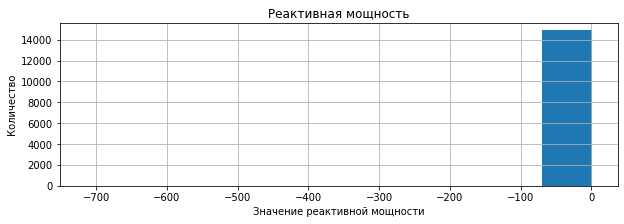

In [25]:
data_arc_new['реактивная_мощность'].hist(figsize=(10,3))
plt.title('Реактивная мощность')
plt.xlabel("Значение реактивной мощности")
plt.ylabel("Количество")

count    14876.000000
mean         0.438986
std          5.873485
min       -715.479924
25%          0.337175
50%          0.441639
75%          0.608201
max          1.270284
Name: реактивная_мощность, dtype: float64

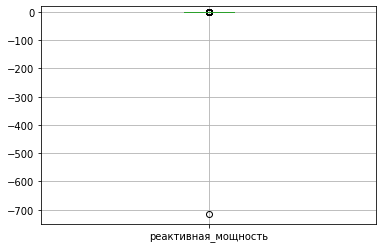

In [26]:
plt.ylim(-750, 20)
data_arc_new.boxplot(['реактивная_мощность'])
data_arc_new['реактивная_мощность'].describe()

Как видно по графикам, это явный выброс. Так как у нас объект прогнозирования это ковш, я удалю из таблицы все строки по ковшу 2116.

In [27]:
data_arc_new = data_arc_new.loc[data_arc_new['key'] != 2116]
data_arc_new.sort_values(by='реактивная_мощность')

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность
709,152,2019-05-09 11:26:58,2019-05-09 11:29:41,0.228852,0.153777
3290,711,2019-05-31 07:16:01,2019-05-31 07:20:05,0.242989,0.153921
11794,2567,2019-08-13 05:51:16,2019-08-13 05:52:22,0.288314,0.155221
6130,1336,2019-06-22 15:46:26,2019-06-22 15:47:50,0.244191,0.156525
9014,1954,2019-07-21 06:26:02,2019-07-21 06:29:01,0.235934,0.157519
...,...,...,...,...,...
8963,1944,2019-07-20 14:55:25,2019-07-20 14:59:27,1.399275,1.214912
14115,3069,2019-08-31 20:02:33,2019-08-31 20:04:24,1.339945,1.222632
8116,1759,2019-07-07 22:52:07,2019-07-07 22:56:35,1.381885,1.223063
3452,748,2019-06-01 16:24:02,2019-06-01 16:26:16,1.374768,1.258628


count    14872.000000
mean         0.487112
std          0.197623
min          0.153777
25%          0.337175
50%          0.441667
75%          0.608201
max          1.270284
Name: реактивная_мощность, dtype: float64

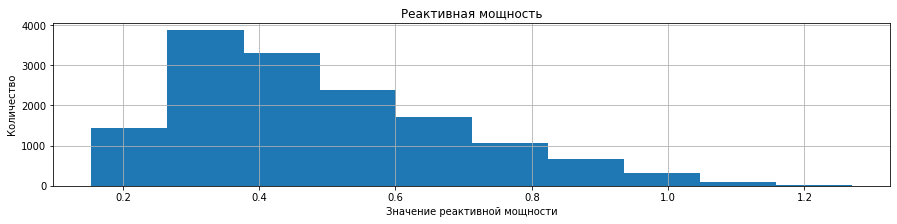

In [28]:
data_arc_new['реактивная_мощность'].hist(figsize=(15,3))
plt.title('Реактивная мощность')
plt.xlabel("Значение реактивной мощности")
plt.ylabel("Количество")
data_arc_new['реактивная_мощность'].describe()

count    14872.000000
mean         0.662753
std          0.258916
min          0.223120
25%          0.467114
50%          0.599587
75%          0.830314
max          1.463773
Name: активная_мощность, dtype: float64

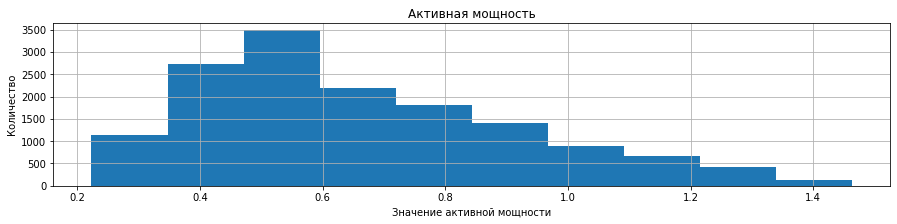

In [29]:
data_arc_new['активная_мощность'].hist(figsize=(15,3))
plt.title('Активная мощность')
plt.xlabel("Значение активной мощности")
plt.ylabel("Количество")
data_arc_new['активная_мощность'].describe()

Первая запись: 2019-05-03 11:02:14
Последняя запись: 2019-09-06 17:24:54


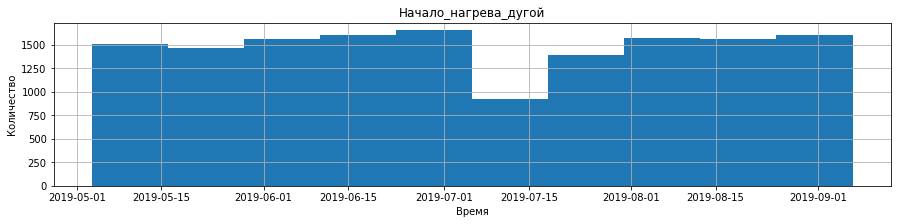

In [30]:
data_arc_new['начало_нагрева_дугой'].hist(figsize=(15,3))
plt.title('Начало_нагрева_дугой')
plt.xlabel("Время")
plt.ylabel("Количество")
print('Первая запись:', data_arc_new['начало_нагрева_дугой'].min())
print('Последняя запись:', data_arc_new['начало_нагрева_дугой'].max())

Первая запись: 2019-05-03 11:06:02
Последняя запись: 2019-09-06 17:26:15


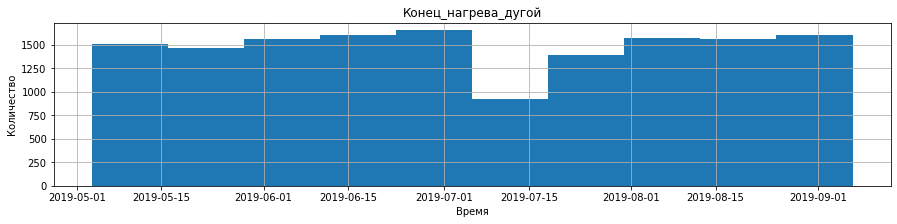

In [31]:
data_arc_new['конец_нагрева_дугой'].hist(figsize=(15,3))
plt.title('Конец_нагрева_дугой')
plt.xlabel("Время")
plt.ylabel("Количество")
print('Первая запись:', data_arc_new['конец_нагрева_дугой'].min())
print('Последняя запись:', data_arc_new['конец_нагрева_дугой'].max())

Посмотрим какое количество времении рабатал негрев в секундах, так можно проверить анамалии во врмени работы нагрева, а также думаю данную инорфмацию можно использовать как параметр при обучении модели.

In [32]:
data_arc_new['рабочее_время'] = data_arc_new['конец_нагрева_дугой'] - data_arc_new['начало_нагрева_дугой']
data_arc_new['рабочее_время'] = data_arc_new['рабочее_время'].astype('timedelta64[s]')
data_arc_new

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,рабочее_время
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0
...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157.0
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180.0
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184.0
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57.0


count    14872.000000
mean       171.688004
std         98.193604
min         11.000000
25%        107.000000
50%        147.000000
75%        214.000000
max        907.000000
Name: рабочее_время, dtype: float64

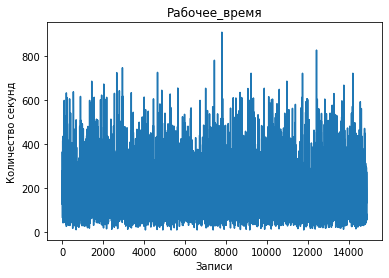

In [33]:
data_arc_new['рабочее_время'].plot()
plt.title('Рабочее_время')
plt.xlabel("Записи")
plt.ylabel("Количество секунд")
data_arc_new['рабочее_время'].describe()

Text(0, 0.5, 'Количество записей')

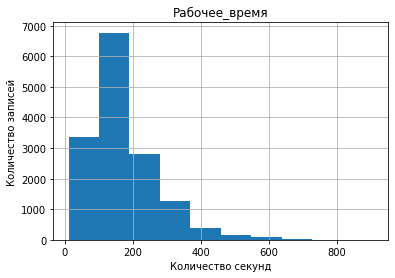

In [34]:
data_arc_new['рабочее_время'].hist()
plt.title('Рабочее_время')
plt.xlabel("Количество секунд")
plt.ylabel("Количество записей")

<AxesSubplot:>

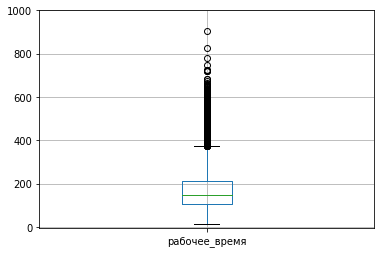

In [35]:
plt.ylim(-5, 1000)
data_arc_new.boxplot(['рабочее_время'])

График и гистаграмма показывают нам нормальное распределение, яшик с усами показывает наличие выбросов, однако максимальное время разогрева согласно таблице чуть более 15 минут, учитывая что изначальное качество стали нам не известно, а также при добавлении легирующих материалов происходит дополнительный нагрев, который зависит от объема добавленных материалов, считаю что лучше не корректировать выборку. Также думаю, данный показатель следует оставить в итоговой таблице как один из параметров.

Добавим к таблице информацию о полной электрической мощности, которая была затрачена на нагрев, по формуле Пифагора: 
$$
S = √ P^2 + Q^2,
$$
где:
- S Полная мощность 
- P Активная мощность
- Q Реактивная мощность

In [36]:
data_arc_new['полная_мощность'] = (data_arc_new['активная_мощность']**2  + data_arc_new['реактивная_мощность']**2)*0.5
data_arc_new

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,рабочее_время,полная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.068866
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.407090
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.261029
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.206611
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,0.583129
...,...,...,...,...,...,...,...
14871,3241,2019-09-06 16:49:05,2019-09-06 16:51:42,0.439735,0.299579,157.0,0.141557
14872,3241,2019-09-06 16:55:11,2019-09-06 16:58:11,0.646498,0.458240,180.0,0.313972
14873,3241,2019-09-06 17:06:48,2019-09-06 17:09:52,1.039726,0.769302,184.0,0.836428
14874,3241,2019-09-06 17:21:58,2019-09-06 17:22:55,0.530267,0.361543,57.0,0.205948


count    14872.000000
mean         0.391302
std          0.311121
min          0.038010
25%          0.167512
50%          0.278699
75%          0.530851
max          1.801502
Name: полная_мощность, dtype: float64

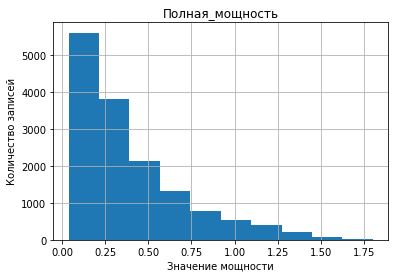

In [37]:
data_arc_new['полная_мощность'].hist()
plt.title('Полная_мощность')
plt.xlabel("Значение мощности")
plt.ylabel("Количество записей")
data_arc_new['полная_мощность'].describe()

Если сравнить графики полной мощности с активной и реактивной, видно что медиана и среднее сместились влево, что соответствует частному случаю нормального распределения.

**Так как у нас объект моделирования ковш, данные по времени начала и окончания нагрева, а также отдельная информация по активной и реативной можности нам не понадобиться. Поэтому сгруппируем данные по номеру партии, рабочему времени и полной мощности:**

In [38]:
data_arc_new.head(5)

,key,начало_нагрева_дугой,конец_нагрева_дугой,активная_мощность,реактивная_мощность,рабочее_время,полная_мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.305130,0.211253,228.0,0.068866
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.765658,0.477438,185.0,0.407090
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.580313,0.430460,172.0,0.261029
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,0.518496,0.379979,365.0,0.206611
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.867133,0.643691,148.0,0.583129


In [39]:
data_1 = data_arc_new.pivot_table(index = 'key', values = ('рабочее_время', 'полная_мощность'), aggfunc = ('sum'))
data_1.reset_index(inplace= True)
data_1

,key,полная_мощность,рабочее_время
0,1,1.526725,1098.0
1,2,0.978428,811.0
2,3,2.878388,655.0
3,4,1.607567,741.0
4,5,1.123995,869.0
...,...,...,...
3208,3237,1.435005,909.0
3209,3238,0.546392,546.0
3210,3239,2.415132,1216.0
3211,3240,1.972458,839.0


**Вывод по таблице `data_arc_new`:**  
Размерность датафрейма `data_arc_new` 14876 строк и 5 столбцов.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Пропуски и дубликаты отсутствуют.  
Удалена аномалия в столбце `реактивная_мощность` - `-715.479924`. Так как объектом моделирования является ковш, 
удалены все записи относительно ковша `2116` в котором выявлена аномалия.  

Добавлен столбец `рабочее_время` с информацией о потраченном на разогрев времени.  
Добавлен столбец `полная_мощность`  в котором посчитана полная электрическая мощность 
потраченная для разогрева стали, по формуле Пифагора: S = √ P^2 + Q^2.  

По итогу предобработки создан датафрейм `data_1`, который включает сгруппированные по ковшу данные, 
планирую использовать эту таблицу для моделирования. `data_1` включает столбцы: `key`, `рабочее_время`, `полная_мощность`.

---

### **data_bulk_new — данные о подаче сыпучих материалов (объём)**  
key — номер партии;  
Bulk 1 … Bulk 15 — объём подаваемого материала.

Фиксируем размерность:

In [40]:
print('Номер первой партии:', data_bulk_new['key'].min())
print('Номер последней партии:', data_bulk_new['key'].max())
data_bulk_new_sh1 = data_bulk_new.shape
data_bulk_new_sh1

Номер первой партии: 1
Номер последней партии: 3241


(3129, 16)

Приводим названия столбцов к стандарту:

In [41]:
rep_rec(data_bulk_new)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


Выводим основные характеристики по датафрейму:

In [42]:
pred(data_bulk_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


(None,
                key      bulk_1      bulk_2       bulk_3       bulk_4  \
 count  3129.000000  252.000000   22.000000  1298.000000  1014.000000   
 mean   1624.383509   39.242063  253.045455   113.879045   104.394477   
 std     933.337642   18.277654   21.180578    75.483494    48.184126   
 min       1.000000   10.000000  228.000000     6.000000    12.000000   
 25%     816.000000   27.000000  242.000000    58.000000    72.000000   
 50%    1622.000000   31.000000  251.500000    97.500000   102.000000   
 75%    2431.000000   46.000000  257.750000   152.000000   133.000000   
 max    3241.000000  185.000000  325.000000   454.000000   281.000000   
 
            bulk_5      bulk_6      bulk_7  bulk_8      bulk_9     bulk_10  \
 count   77.000000  576.000000   25.000000     1.0   19.000000  176.000000   
 mean   107.025974  118.925347  305.600000    49.0   76.315789   83.284091   
 std     81.790646   72.057776  191.022904     NaN   21.720581   26.060347   
 min     11.000000   1

array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'bulk_1'}>,
        <AxesSubplot:title={'center':'bulk_2'}>,
        <AxesSubplot:title={'center':'bulk_3'}>],
       [<AxesSubplot:title={'center':'bulk_4'}>,
        <AxesSubplot:title={'center':'bulk_5'}>,
        <AxesSubplot:title={'center':'bulk_6'}>,
        <AxesSubplot:title={'center':'bulk_7'}>],
       [<AxesSubplot:title={'center':'bulk_8'}>,
        <AxesSubplot:title={'center':'bulk_9'}>,
        <AxesSubplot:title={'center':'bulk_10'}>,
        <AxesSubplot:title={'center':'bulk_11'}>],
       [<AxesSubplot:title={'center':'bulk_12'}>,
        <AxesSubplot:title={'center':'bulk_13'}>,
        <AxesSubplot:title={'center':'bulk_14'}>,
        <AxesSubplot:title={'center':'bulk_15'}>]], dtype=object)

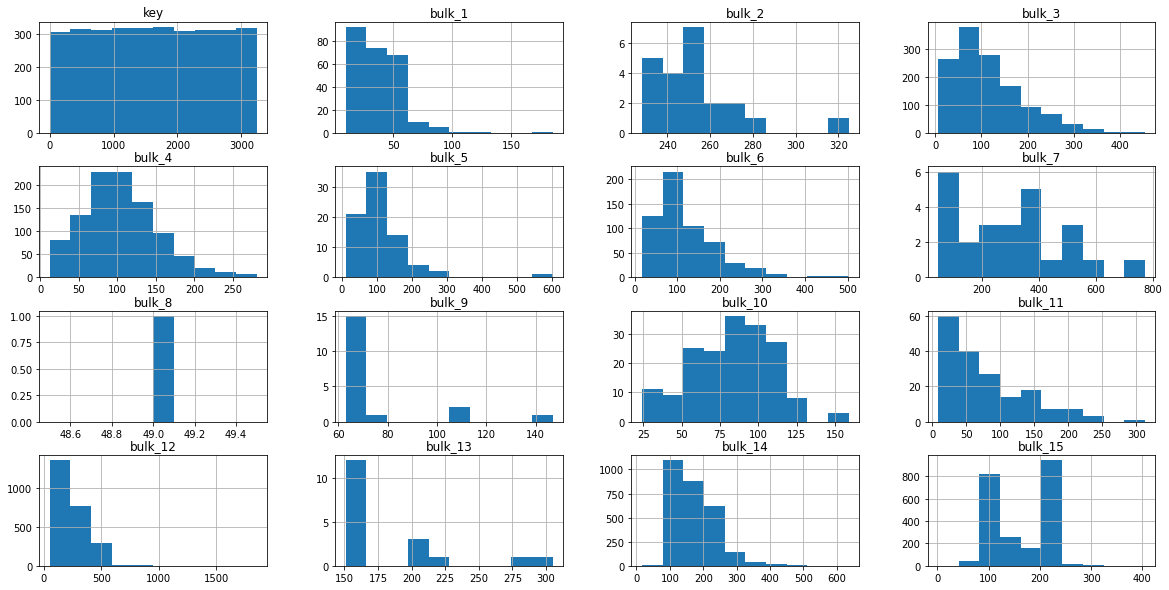

In [43]:
data_bulk_new.hist(figsize=(20,10))

Типы данных присвоены верно, дубликаты отсутствуют, пропусков очень много по столбцам `bulk_1` - `bulk_15`.  
Учитывая что `bulk_1` - `bulk_15` это разные виды сыпучих материалов, которые подают в ковш для того, чтобы изменить состав сплава, сложно оценить адекватность количества добавленных сыпучих материалов, т.к. не известен изначальный состав сплава и не известно что зашефрованно за аббревиатурой `bulk`.  

`NaN` не буду заментья на "0", сделаю это после объединения данных, т.к. "0" будут сильно влиять на выводы данных.

Также дабавлю столбец `итого_bulk`, в которм посчитаю общее количество добавленных 
материалов в ковш, а также столбец `bulk_count` в котором посчитаем какое количество раз
в ковш добавлялись дополнительные материалы.

In [44]:
data_bulk_new['bulk_count'] = data_bulk_new.apply(lambda row: row['bulk_1' : 'bulk_15'].count(),axis=1)
data_bulk_new['итого_bulk'] = data_bulk_new.apply(lambda row: row['bulk_1' : 'bulk_15'].sum(),axis=1)
data_bulk_new

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_count,итого_bulk
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,4,553.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,4,582.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,4,544.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,4,595.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,4,584.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0,4,758.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0,4,594.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0,4,630.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0,3,272.0


count    3129.000000
mean      595.503356
std       276.557794
min        19.000000
25%       429.000000
50%       591.000000
75%       772.000000
max      3235.000000
Name: итого_bulk, dtype: float64

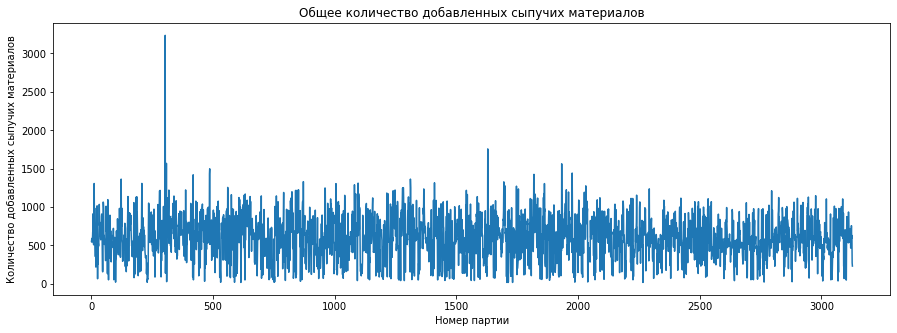

In [45]:
data_bulk_new['итого_bulk'].plot(figsize=(15,5))
plt.title('Общее количество добавленных сыпучих материалов')
plt.xlabel("Номер партии")
plt.ylabel("Количество добавленных сыпучих материалов")

data_bulk_new['итого_bulk'].describe()

<AxesSubplot:>

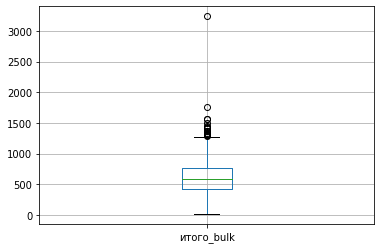

In [46]:
data_bulk_new.boxplot(['итого_bulk'])

count    3129.000000
mean        3.566315
std         1.216165
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
Name: bulk_count, dtype: float64

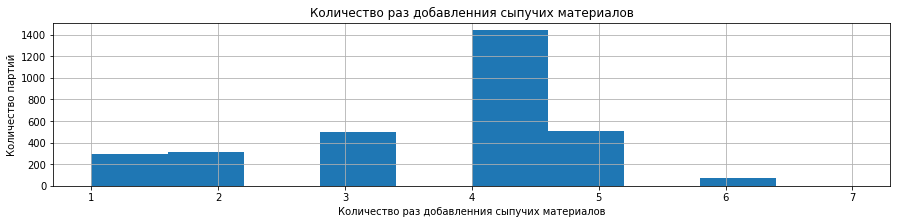

In [47]:
data_bulk_new['bulk_count'].hist(figsize=(15,3))
plt.title('Количество раз добавленния сыпучих материалов')
plt.xlabel("Количество раз добавленния сыпучих материалов")
plt.ylabel("Количество партий")

data_bulk_new['bulk_count'].describe()

<AxesSubplot:>

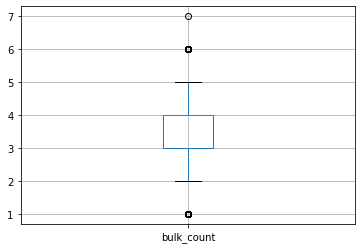

In [48]:
data_bulk_new.boxplot(['bulk_count'])

<AxesSubplot:title={'center':'Зависимость объема добавленных материалов от количества их добавления'}, xlabel='итого_bulk', ylabel='bulk_count'>

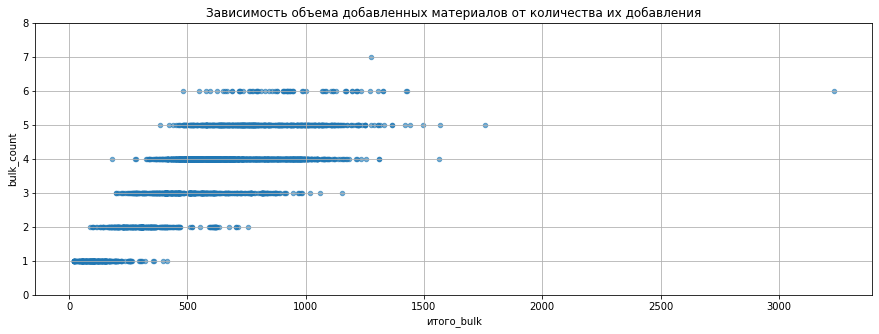

In [49]:
data_bulk_new.plot(
    x = 'итого_bulk', y = 'bulk_count', 
    title = 'Зависимость объема добавленных материалов от количества их добавления', 
    kind = 'scatter', alpha = 0.6, ylim = (0, 8), figsize = (15, 5), grid = True)

In [50]:
data_bulk_new.sort_values(by='bulk_count', ascending = False).head(3)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_count,итого_bulk
1699,1759,46.0,NaN,212.0,NaN,33.0,121.0,NaN,NaN,NaN,NaN,NaN,410.0,NaN,251.0,205.0,7,1278.0
2664,2765,28.0,NaN,42.0,42.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,226.0,NaN,176.0,222.0,6,736.0
2083,2155,NaN,NaN,62.0,79.0,NaN,NaN,NaN,NaN,NaN,75.0,NaN,363.0,NaN,193.0,211.0,6,983.0


In [51]:
data_bulk_new.sort_values(by='итого_bulk', ascending = False).head(3)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_count,итого_bulk
303,322,185.0,NaN,101.0,58.0,NaN,NaN,406.0,NaN,NaN,NaN,NaN,1849.0,NaN,636.0,NaN,6,3235.0
1629,1689,NaN,NaN,NaN,NaN,NaN,247.0,NaN,NaN,NaN,NaN,NaN,733.0,305.0,248.0,224.0,5,1757.0
308,327,67.0,NaN,NaN,119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,775.0,NaN,403.0,205.0,5,1569.0


Согласно графиков по `bulk_count` выбросом можно считать партию под номером `1759`, т.к. это единственная партия в которую 7 раз были добавлены сыпучие материалы.

Согласно графиков по `итого_bulk` в партию под номером `322` в общей сложности было добавленно 3235 сыпучих материалов, что в два раза больше чем максимальные значения по другим ковшам. 

**На данном этапе удалять эти аномалии не буду, посмотрю еще раз на данные в объединенном файле.**

count    3129.000000
mean      595.503356
std       276.557794
min        19.000000
25%       429.000000
50%       591.000000
75%       772.000000
max      3235.000000
Name: итого_bulk, dtype: float64

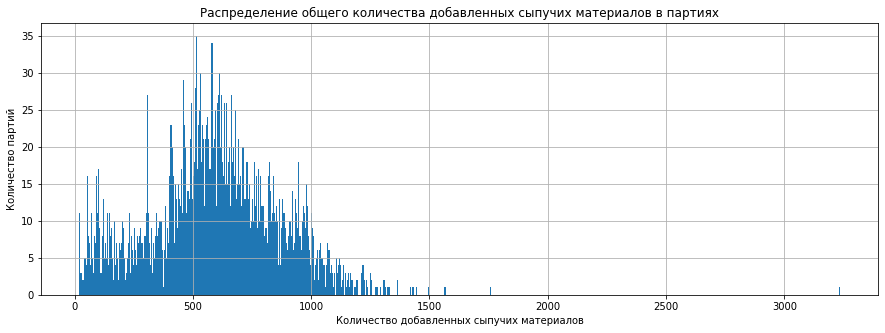

In [52]:
data_bulk_new['итого_bulk'].hist(bins = 782, figsize=(15,5))
plt.title('Распределение общего количества добавленных сыпучих материалов в партиях')
plt.xlabel("Количество добавленных сыпучих материалов")
plt.ylabel("Количество партий")
data_bulk_new['итого_bulk'].describe()

Распределение стремиться к нормальному, но есть несколько всплесков в райное: 100-150, 300, 900. Думаю это связанно с изначальным качеством стали, обычно такая ситуация складывается когда есть несколько источников данных, например несколько поставщиков стали или один поставщик, но который привозит руду из разных мест добычи. В связи с этим оставлю данные как есть.

**Вывод по таблице `data_bulk_new`:**  
Размерность датафрейма `data_bulk_new` 3129 строк и 16 столбцов.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Дубликаты отсутствуют.  
Большое количество пропусков по столбцам `bulk_1` - `bulk_15`.  
Пропуски не заполняла, сделаю это после объединения данных.

Добавлен столбец `итого_bulk`, в котором посчитан общий объем добавленных сыпучих материалов по каждому ковшу и `bulk_count` за какое количество раз они были добавлены в ковш.

В `итого_bulk` выбросом можно считать партию под номером `322` куда, в общей сложности было добавлено 3235 сыпучих материалов, что в два раза больше чем максимальные значения по другим ковшам, но пока данный ковш удалять не буду. Посмотрю на данные еще раз после объединения.

В `bulk_count` выбросом можно считать партию под номером `1759`, т.к. это единственная партия в которую 7 раз были добавлены сыпучие материалы, аналогично посмотрю на данные еще раз после объединения данных.

Распределение данных в столбце `итого_bulk`стремиться к нормальному, 
но есть несколько всплесков в районе: 100-150, 300, 900. Полагаю это связанно с несколькими источниками 
изначальной стали подаваемой в ковш, поэтому данные не корректировались.  

Данные я не агрегировала в новую таблицу, т.к. каждая строка датафрейма `data_bulk_new` соответствует отдельному ковшу,
и  считаю что в итоговой таблице стоит оставить столбцы `bulk_1` - `bulk_15` поскольку аббревиатурой `bulk_...`
зашифрован определенный химический элемент и раз в процессе производства стали их разделяют, 
значит скорее всего это важно.

---

### **data_bulk_time_new — данные о подаче сыпучих материалов (время)**
key — номер партии;  
Bulk 1 … Bulk 15 — время подачи материала.

Фиксируем размерность:

In [53]:
print('Номер первой партии:', data_bulk_time_new['key'].min())
print('Номер последней партии:', data_bulk_time_new['key'].max())
data_bulk_time_new_sh1 = data_bulk_time_new.shape
data_bulk_time_new_sh1

Номер первой партии: 1
Номер последней партии: 3241


(3129, 16)

Приводим названия столбцов к стандарту:

In [54]:
rep_rec(data_bulk_time_new)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36
4,5,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 13:30:47,NaT,2019-05-03 13:34:12,2019-05-03 13:30:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaT,NaT,2019-09-06 11:54:15,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 11:49:45,NaT,2019-09-06 11:45:22,2019-09-06 11:40:06
3125,3238,NaT,NaT,2019-09-06 12:26:52,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 12:18:35,NaT,2019-09-06 12:31:49,2019-09-06 12:26:52
3126,3239,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:06:00,NaT,NaT,NaT,NaT,NaT,2019-09-06 15:01:44,NaT,2019-09-06 14:58:15,2019-09-06 14:48:06
3127,3240,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:24:28,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-09-06 16:07:29,2019-09-06 16:01:34


Выводим основные характеристики по датафрейму:

In [55]:
pred(data_bulk_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   key      3129 non-null   int64         
 1   bulk_1   252 non-null    datetime64[ns]
 2   bulk_2   22 non-null     datetime64[ns]
 3   bulk_3   1298 non-null   datetime64[ns]
 4   bulk_4   1014 non-null   datetime64[ns]
 5   bulk_5   77 non-null     datetime64[ns]
 6   bulk_6   576 non-null    datetime64[ns]
 7   bulk_7   25 non-null     datetime64[ns]
 8   bulk_8   1 non-null      datetime64[ns]
 9   bulk_9   19 non-null     datetime64[ns]
 10  bulk_10  176 non-null    datetime64[ns]
 11  bulk_11  177 non-null    datetime64[ns]
 12  bulk_12  2450 non-null   datetime64[ns]
 13  bulk_13  18 non-null     datetime64[ns]
 14  bulk_14  2806 non-null   datetime64[ns]
 15  bulk_15  2248 non-null   datetime64[ns]
dtypes: datetime64[ns](15), int64(1)
memory usage: 391.2 KB


(None,
                key
 count  3129.000000
 mean   1624.383509
 std     933.337642
 min       1.000000
 25%     816.000000
 50%    1622.000000
 75%    2431.000000
 max    3241.000000,
 0,
 key           0
 bulk_1     2877
 bulk_2     3107
 bulk_3     1831
 bulk_4     2115
 bulk_5     3052
 bulk_6     2553
 bulk_7     3104
 bulk_8     3128
 bulk_9     3110
 bulk_10    2953
 bulk_11    2952
 bulk_12     679
 bulk_13    3111
 bulk_14     323
 bulk_15     881
 dtype: int64)

**Типы данных присвоены верно, дубликаты отсутствуют, пропусков очень много по 
столбцам `bulk_1` - `bulk_15`.**

 Добавим в датафрейм столбец `итого_bulk_time` в котором посчитаем количество добавленных присадок по каждой партии:

In [56]:
data_bulk_time_new['итого_bulk_time'] = data_bulk_time_new.apply(lambda row: row['bulk_1' : 'bulk_15'].count(),axis=1)

count    3129.000000
mean        3.566315
std         1.216165
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         7.000000
Name: итого_bulk_time, dtype: float64

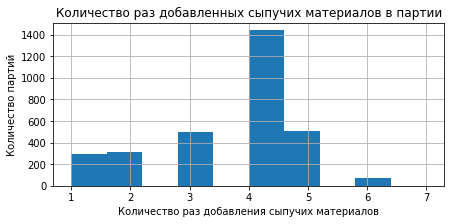

In [57]:
data_bulk_time_new['итого_bulk_time'].hist(figsize=(7,3))
plt.title('Количество раз добавленных сыпучих материалов в партии')
plt.xlabel("Количество раз добавления сыпучих материалов")
plt.ylabel("Количество партий")
data_bulk_time_new['итого_bulk_time'].describe()

Распределение количества применяемых присаждок для одной партии имеет норманый вид. Есть нкоторое количество партий в которых применялить дополнительные материалы всего 1-2 раза, что коррелируется с таблицей по добавлению сыпучих материалов в объеме материала: там также был всплеск в начале гистограммы. Поэтому корректировать данные не буду.

array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'bulk_1'}>,
        <AxesSubplot:title={'center':'bulk_2'}>,
        <AxesSubplot:title={'center':'bulk_3'}>],
       [<AxesSubplot:title={'center':'bulk_4'}>,
        <AxesSubplot:title={'center':'bulk_5'}>,
        <AxesSubplot:title={'center':'bulk_6'}>,
        <AxesSubplot:title={'center':'bulk_7'}>],
       [<AxesSubplot:title={'center':'bulk_8'}>,
        <AxesSubplot:title={'center':'bulk_9'}>,
        <AxesSubplot:title={'center':'bulk_10'}>,
        <AxesSubplot:title={'center':'bulk_11'}>],
       [<AxesSubplot:title={'center':'bulk_12'}>,
        <AxesSubplot:title={'center':'bulk_13'}>,
        <AxesSubplot:title={'center':'bulk_14'}>,
        <AxesSubplot:title={'center':'bulk_15'}>],
       [<AxesSubplot:title={'center':'итого_bulk_time'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

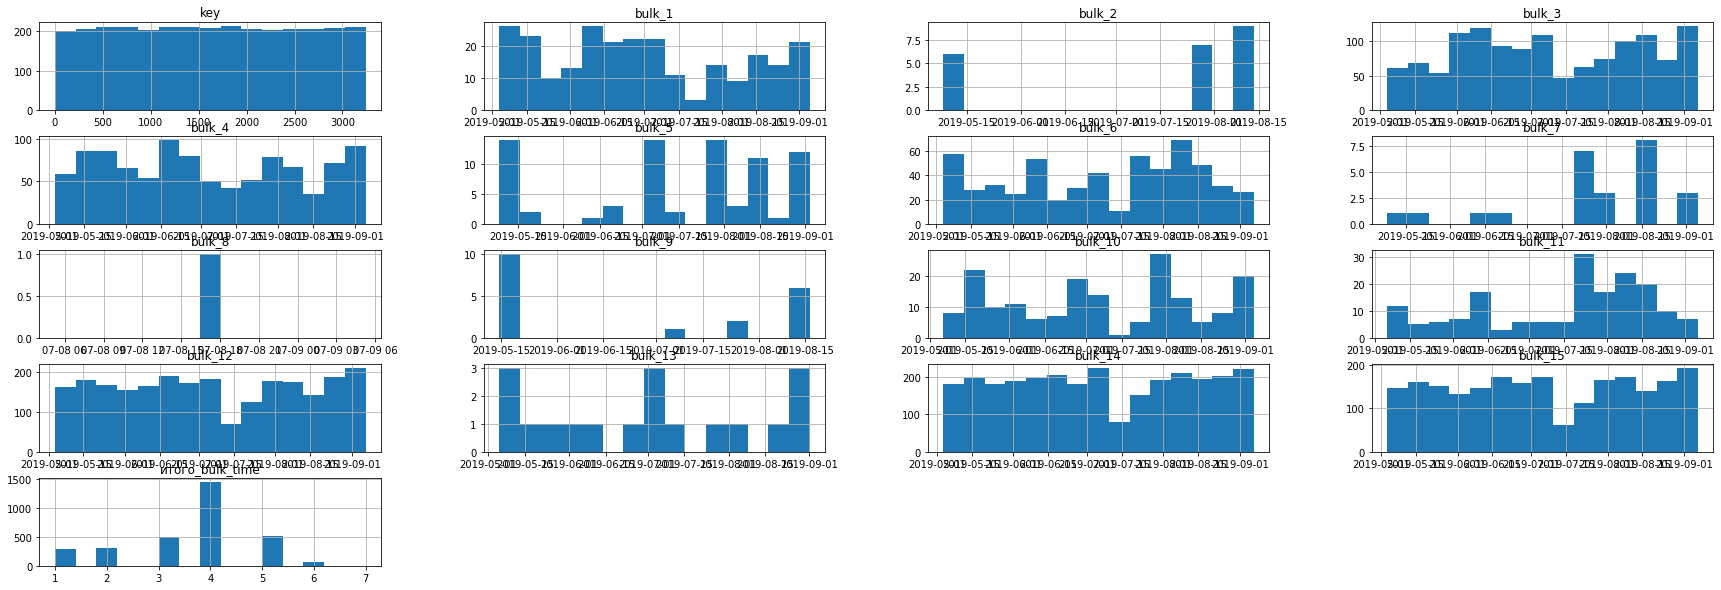

In [58]:
data_bulk_time_new.hist(bins = 15, figsize=(30,10))

Как видно по графикам, все `bulk` применяются по несколько раз за иследуемый период, только `bulk_8` применяется лишь однажы. Посмотрим на этот ковш.

In [59]:
data_bulk_time_new.sort_values(by='bulk_8', ascending = False).head(5)

,key,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,итого_bulk_time
1725,1786,NaT,NaT,2019-07-08 17:14:53,NaT,NaT,NaT,NaT,2019-07-08 17:14:53,2019-07-08 17:23:24,NaT,NaT,NaT,NaT,NaT,NaT,3
0,1,NaT,NaT,NaT,2019-05-03 11:28:48,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:24:31,NaT,2019-05-03 11:14:50,2019-05-03 11:10:43,4
1,2,NaT,NaT,NaT,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 11:53:30,NaT,2019-05-03 11:48:37,2019-05-03 11:44:39,4
2,3,NaT,NaT,NaT,2019-05-03 12:32:39,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:27:13,NaT,2019-05-03 12:21:01,2019-05-03 12:16:16,4
3,4,NaT,NaT,NaT,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2019-05-03 12:58:00,NaT,2019-05-03 12:51:11,2019-05-03 12:46:36,4


Ковш 1786 кроме присадки `bulk_8` имеет также присадки по `bulk_3` и `bulk_9`. Соответственно считать даный ковш аномалией будет неверно.

**Вывод по таблице `data_bulk_time_new`:**  
Размерность датафрейма `data_bulk_time_new` 3129 строк и 16 столбцов.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Дубликаты отсутствуют.  
Большое количество пропусков по столбцам `bulk_1` - `bulk_15`, которые буду корректировать уже после объединения таблиц.

Добавлен столбец `итого_bulk_time`, в котором посчитано какое количество раз
в ковш были добавлены сыпуче материалы. Распределение данных в столбце `итого_bulk_time` имеет нормальный вид. 
Поэтому считаю что нет необходимости в корректировке данных, что также подтверждается схожестью распределений `data_bulk_new['итого_bulk']` и `data_bulk_time_new['итого_bulk_time']`.

Данные из таблицы `data_bulk_time_new` я не планирую использовать при моделировании, поскольку 
уже есть данные по объемам добавленных материалов, точное время их добавления считаю ненужной 
и излишней информацией.

---

### **data_gas_new — данные о продувке сплава газом**
key — номер партии;  
Газ 1 — объём подаваемого газа.

Фиксируем размерность:

In [60]:
print('Номер первой партии:', data_gas_new['key'].min())
print('Номер последней партии:', data_gas_new['key'].max())
data_gas_new_sh1 = data_gas_new.shape
data_gas_new_sh1

Номер первой партии: 1
Номер последней партии: 3241


(3239, 2)

Приводим названия столбцов к стандарту:

In [61]:
rep_rec(data_gas_new)

,key,газ_1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


Выводим основные характеристики по датафрейму:

In [62]:
pred(data_gas_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   газ_1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


(None,
                key        газ_1
 count  3239.000000  3239.000000
 mean   1621.861377    11.002062
 std     935.386334     6.220327
 min       1.000000     0.008399
 25%     812.500000     7.043089
 50%    1622.000000     9.836267
 75%    2431.500000    13.769915
 max    3241.000000    77.995040,
 0,
 key      0
 газ_1    0
 dtype: int64)

**Типы данных присвоены верно, дубликаты и пропуски отсутствуют.**

Посмотрим на распредление данных:

<AxesSubplot:>

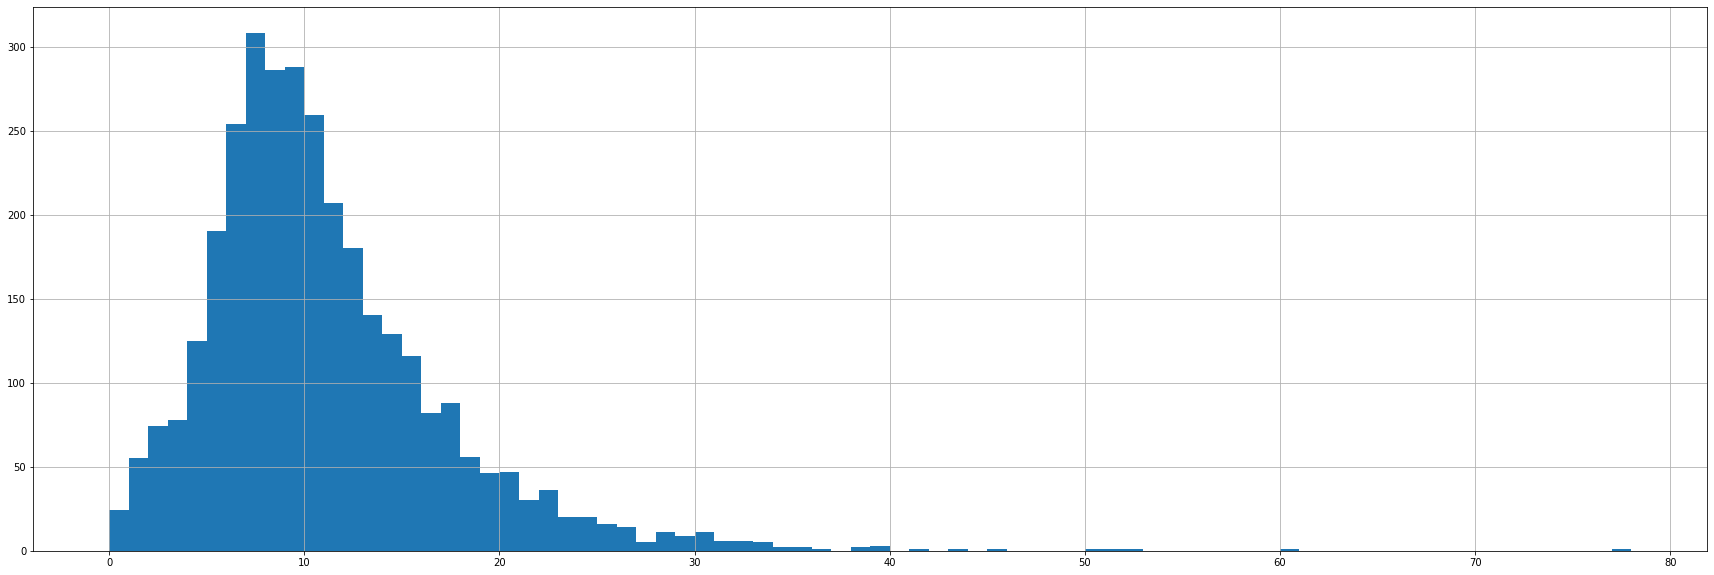

In [63]:
data_gas_new['газ_1'].hist(bins = 78, figsize=(30,10))

Распределение имеет нормальный вид, но у него большое количество выбросов в правую сторону. Посмотрим график распределений по партиям и ящик с усами.

<AxesSubplot:>

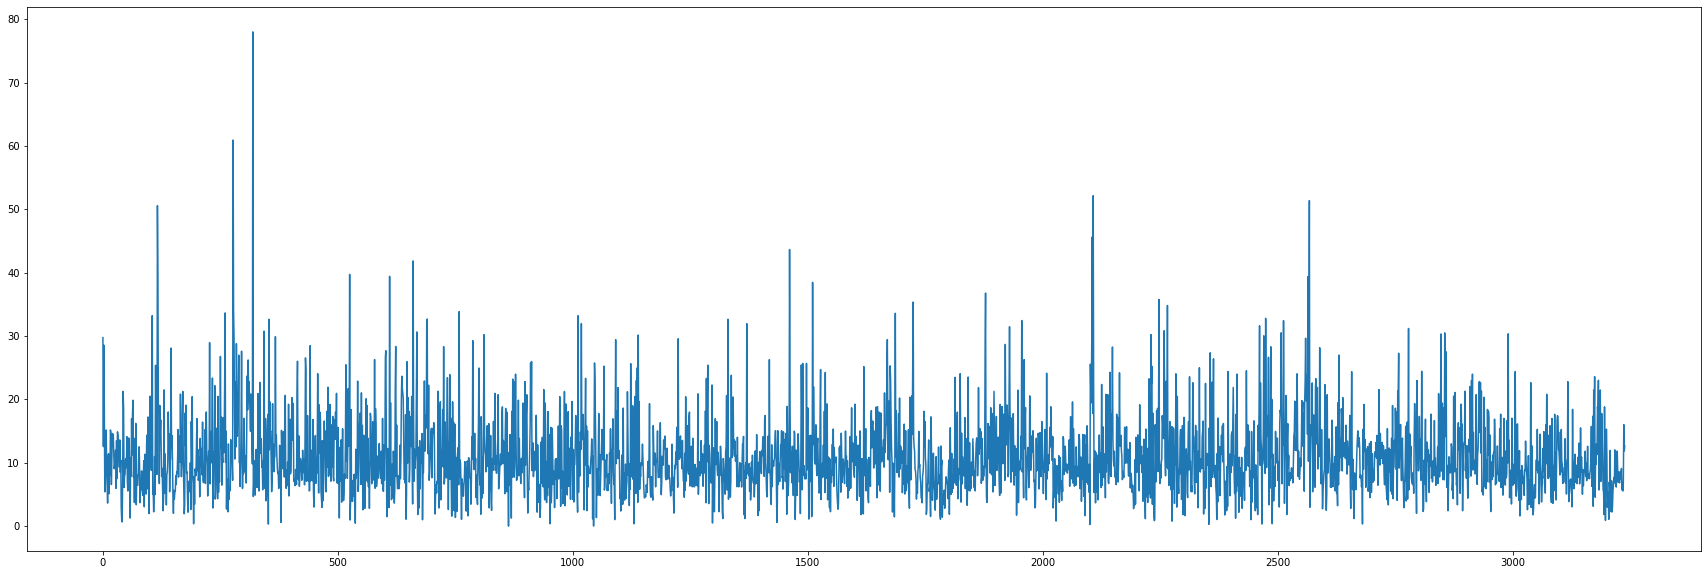

In [64]:
data_gas_new['газ_1'].plot(figsize=(30,10))

<AxesSubplot:>

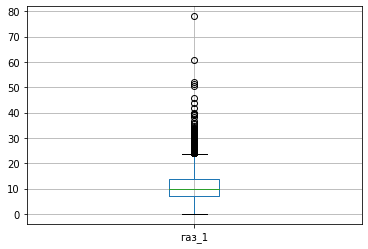

In [65]:
data_gas_new.boxplot(['газ_1'])

In [66]:
data_gas_new.sort_values(by='газ_1', ascending = False).head(10)

,key,газ_1
319,322,77.995040
277,280,60.935689
2107,2110,52.142373
2567,2570,51.380229
116,117,50.581035
2105,2108,45.638999
1461,1464,43.655411
660,663,41.854643
525,528,39.728826
610,613,39.425706


Как видно из графиков значения более 40 являются выбросами, однако у нас есть партии стали в которые было добавлено большое количество дополнительных материалов для того чтобы получить эталонную сталь, и так как каждый раз после добавления новых материалов происходит продувка газом, возможно такое большое количество газа связанно именно с такими партиями.  
  
В связи с этим сейчас я не буду корректировать данные, но зафиксирую себе партии стали со значением более 40 по количеству добавленного газа (до 40 также есть выбросы но они находятся в допустимой области и расположены достаточно близко друг другу что говорит о их допустимости), чтобы проверить их еще раз после объединения таблиц.

**Вывод по таблице `data_gas_new`:**  
Размерность датафрейма `data_gas_new` 3239 строк и 2 столбца.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Дубликаты и пропуски отсутствуют.  

Распределение данных по столбцу `газ_1` имеет нормальный вид, 
но у него большое количество выбросов в правую сторону. 
Считаю что значения более 40 можно считать выбросами, 
но так как количество поданного газа указано в суммарном виде, без указания на
 времени добавления, думаю будет правильно еще раз посмотреть на эти данные
 после объединения таблиц и сопоставить их с объемом добавленных материалов.  
  
Данную таблицу буду использовать при моделировании, дополнительная модификация здесь не требуется, 
т.к. объемы газа уже сгруппированы по партиям. 

---

### **data_wire_new — данные о проволочных материалах (объём)**
key — номер партии;  
Wire 1 … Wire 15 — объём подаваемых проволочных материалов.

Фиксируем размерность:

In [67]:
print('Номер первой партии:', data_wire_new['key'].min())
print('Номер последней партии:', data_wire_new['key'].max())
data_wire_new_sh1 = data_wire_new.shape
data_wire_new_sh1

Номер первой партии: 1
Номер последней партии: 3241


(3081, 10)

Приводим названия столбцов к стандарту:

In [68]:
rep_rec(data_wire_new)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Выводим основные характеристики по датафрейму:

In [69]:
pred(data_wire_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


(None,
                key       wire_1       wire_2      wire_3      wire_4  wire_5  \
 count  3081.000000  3055.000000  1079.000000   63.000000   14.000000   1.000   
 mean   1623.426485   100.895853    50.577323  189.482681   57.442841  15.132   
 std     932.996726    42.012518    39.320216   99.513444   28.824667     NaN   
 min       1.000000     1.918800     0.030160    0.144144   24.148801  15.132   
 25%     823.000000    72.115684    20.193680   95.135044   40.807002  15.132   
 50%    1619.000000   100.158234    40.142956  235.194977   45.234282  15.132   
 75%    2434.000000   126.060483    70.227558  276.252014   76.124619  15.132   
 max    3241.000000   330.314424   282.780152  385.008668  113.231044  15.132   
 
            wire_6     wire_7      wire_8     wire_9  
 count   73.000000  11.000000   19.000000  29.000000  
 mean    48.016974  10.039007   53.625193  34.155752  
 std     33.919845   8.610584   16.881728  19.931616  
 min      0.034320   0.234208   45.076721 

array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'wire_1'}>,
        <AxesSubplot:title={'center':'wire_2'}>],
       [<AxesSubplot:title={'center':'wire_3'}>,
        <AxesSubplot:title={'center':'wire_4'}>,
        <AxesSubplot:title={'center':'wire_5'}>],
       [<AxesSubplot:title={'center':'wire_6'}>,
        <AxesSubplot:title={'center':'wire_7'}>,
        <AxesSubplot:title={'center':'wire_8'}>],
       [<AxesSubplot:title={'center':'wire_9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

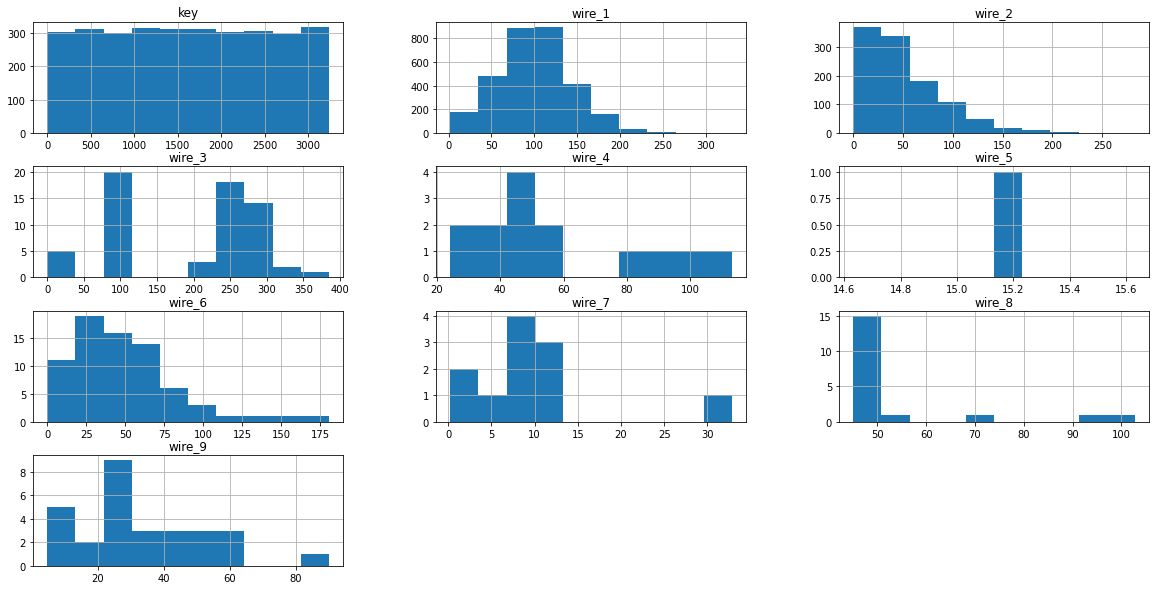

In [70]:
data_wire_new.hist(figsize=(20,10))

Типы данных присвоены верно, дубликаты отсутствуют, пропусков очень много по 
столбцам `wire_1` - `wire_9`.  
Учитывая что `wire_1` - `wire_9` это разные виды материалов,  сложно оценить адекватность их количества, т.к. не известен изначальный состав сплава и неизвестно что именно зашифровано за аббревиатурой `wire`.  

`NaN` не буду заментья на "0", сделаю это после объединения данных, 
т.к. "0" будут сильно влиять на выводы данных.

Также добавлю столбец `итого_wire`, в котором посчитаю общее количество добавленных 
материалов в ковш, а также столбец `итого_wire_count` в котором посчитаю какое количество раз
в ковш добавлялись дополнительные материалы.

In [71]:
data_wire_new['итого_wire_count'] = data_wire_new.apply(lambda row: row['wire_1' : 'wire_9'].count(),axis=1)
data_wire_new['итого_wire'] = data_wire_new.apply(lambda row: row['wire_1' : 'wire_9'].sum(),axis=1)
data_wire_new

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,итого_wire_count,итого_wire
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,60.059998
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,96.052315
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,91.160157
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,89.063515
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,98.352796
...,...,...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,38.088959
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,56.128799
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,143.357761
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,34.070400


Посмотрим на распределения агрегирующих столбцов:

count    3081.000000
mean      123.723326
std        66.082966
min         1.918800
25%        86.112000
50%       114.179523
75%       150.181198
max       663.851766
Name: итого_wire, dtype: float64

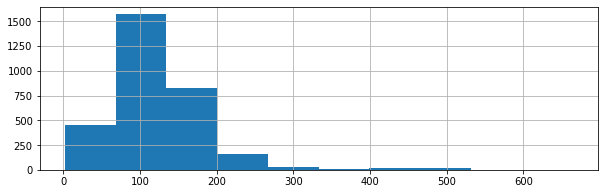

In [72]:
data_wire_new['итого_wire'].hist(figsize=(10,3))
data_wire_new['итого_wire'].describe()

<AxesSubplot:>

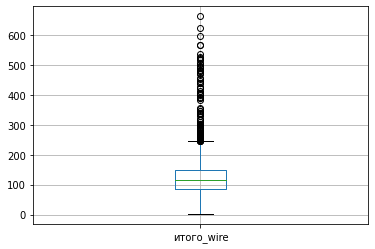

In [73]:
data_wire_new.boxplot(['итого_wire'])

count    3081.000000
mean        1.409932
std         0.578078
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: итого_wire_count, dtype: float64

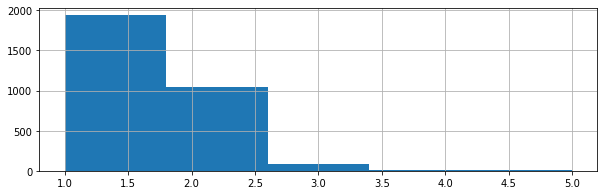

In [74]:
data_wire_new['итого_wire_count'].hist(bins= 5, figsize=(10,3))
data_wire_new['итого_wire_count'].describe()

<AxesSubplot:>

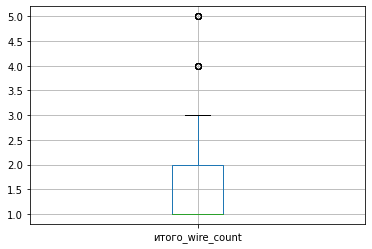

In [75]:
data_wire_new.boxplot(['итого_wire_count'])

<AxesSubplot:title={'center':'Зависимость объема добвленных материалов в ковш от количества раз их добавления'}, xlabel='итого_wire', ylabel='итого_wire_count'>

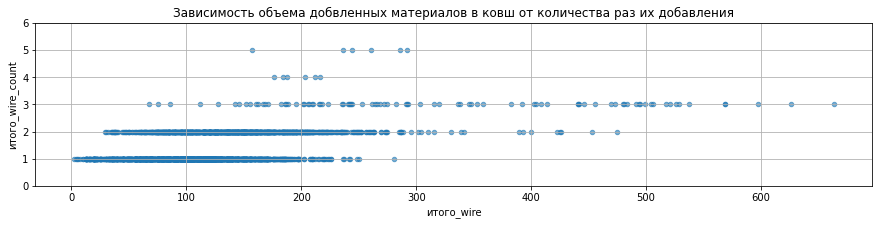

In [76]:
data_wire_new.plot(
    x = 'итого_wire', y = 'итого_wire_count', 
    title = 'Зависимость объема добвленных материалов в ковш от количества раз их добавления', 
    kind = 'scatter', alpha = 0.6, ylim = (0, 6), figsize = (15, 3), grid = True)

Согласно графиков по столбцам `итого_wire` и `итого_wire_count` выбросами можно считать добавленный объем более 370 и добавление материалов в ковш более 4 раз. Но есть опасения что слишком большая корректировка данных может плохо сказаться на итоговой работе модели. Поэтому также зафиксирую себе эти особенности данных и еще раз их посмотрю на объединенных данных.

На гистограмме столбца `wire_5` видно что данный материал применялся только дин раз за исследуемый период, однако если посмотреть на данный ковш видно, что кроме `wire_5`, в него были добавлены также: `wire_1`,`wire_3`,`wire_6`.
Таким образом этот ковш нельзя считать аномалией, в корректировке нет необходимости.

In [77]:
data_wire_new.sort_values(by='wire_5', ascending = False).head(1)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,итого_wire_count,итого_wire
2440,2567,18.30192,NaN,96.288193,NaN,15.132,73.307526,NaN,NaN,NaN,4,203.029639


**Вывод по таблице `data_wire_new`:**
Размерность датафрейма `data_wire_new` 3081 строк и 10 столбцов.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно, дубликаты отсутствуют, пропусков очень много по 
столбцам `wire_1` - `wire_9`.

Учитывая что `wire_1` - `wire_9` это разные виды материалов, сложно оценить адекватность их 
количества, т.к. не известен изначальный состав сплава и неизвестно что именно зашифровано 
за аббревиатурой wire.

Пропуски буду заменять на "0" после объединения данных.

Добавлен столбец `итого_wire`, в котором посчитан общий объем добавленных материалов в ковш.  
Добавлен столбец `итого_wire_count` в котором посчитано какое количество раз 
в ковш добавлялись дополнительные материалы.

Согласно графиков по столбцам `итого_wire` и `итого_wire_count` выбросами можно считать 
добавленный объем более 370 и добавление материалов в ковш более 4 раз. 
Для того чтобы принять более взвешенное решение которое не будет иметь значительное влияние на 
данные, приму решение о корректировке после объединения данных.

Данную таблицу буду использовать при моделировании, дополнительная модификация здесь не требуется, 
т.к. объемы газа уже сгруппированы по партиям. 

---

### **data_wire_time_new — данные о проволочных материалах (время)**
key — номер партии;  
Wire 1 … Wire 15 — время подачи проволочных материалов.

Фиксируем размерность:

In [78]:
print('Номер первой партии:', data_wire_time_new['key'].min())
print('Номер последней партии:', data_wire_time_new['key'].max())
data_wire_time_new_sh1 = data_wire_time_new.shape
data_wire_time_new_sh1

Номер первой партии: 1
Номер последней партии: 3241


(3081, 10)

Приводим названия столбцов к стандарту:

In [79]:
rep_rec(data_wire_time_new)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-09-06 11:33:38,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3077,3238,2019-09-06 12:18:35,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3078,3239,2019-09-06 14:36:11,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
3079,3240,2019-09-06 15:33:55,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT


Выводим основные характеристики по датафрейму:

In [80]:
pred(data_wire_time_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   key     3081 non-null   int64         
 1   wire_1  3055 non-null   datetime64[ns]
 2   wire_2  1079 non-null   datetime64[ns]
 3   wire_3  63 non-null     datetime64[ns]
 4   wire_4  14 non-null     datetime64[ns]
 5   wire_5  1 non-null      datetime64[ns]
 6   wire_6  73 non-null     datetime64[ns]
 7   wire_7  11 non-null     datetime64[ns]
 8   wire_8  19 non-null     datetime64[ns]
 9   wire_9  29 non-null     datetime64[ns]
dtypes: datetime64[ns](9), int64(1)
memory usage: 240.8 KB


(None,
                key
 count  3081.000000
 mean   1623.426485
 std     932.996726
 min       1.000000
 25%     823.000000
 50%    1619.000000
 75%    2434.000000
 max    3241.000000,
 0,
 key          0
 wire_1      26
 wire_2    2002
 wire_3    3018
 wire_4    3067
 wire_5    3080
 wire_6    3008
 wire_7    3070
 wire_8    3062
 wire_9    3052
 dtype: int64)

array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'wire_1'}>,
        <AxesSubplot:title={'center':'wire_2'}>],
       [<AxesSubplot:title={'center':'wire_3'}>,
        <AxesSubplot:title={'center':'wire_4'}>,
        <AxesSubplot:title={'center':'wire_5'}>],
       [<AxesSubplot:title={'center':'wire_6'}>,
        <AxesSubplot:title={'center':'wire_7'}>,
        <AxesSubplot:title={'center':'wire_8'}>],
       [<AxesSubplot:title={'center':'wire_9'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

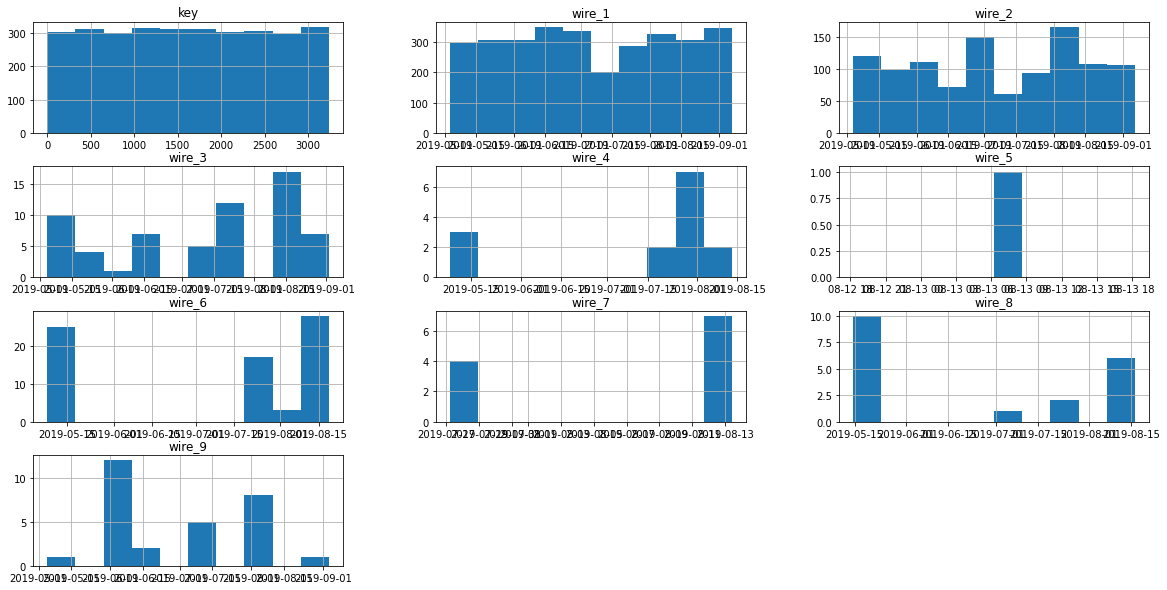

In [81]:
data_wire_time_new.hist(figsize=(20,10))

Типы данных присвоены верно, дубликаты отсутствуют, пропусков очень много по 
столбцам `wire_1` - `wire_9`, аналогично таблице `data_wire_new`.


Добавим в датафрейм столбец `итого_wire_time` в котором посчитаем количество добавленных присадок по каждой партии:

In [82]:
data_wire_time_new['итого_wire_time'] = data_wire_time_new.apply(lambda row: row['wire_1' : 'wire_9'].count(),axis=1)
data_wire_time_new.head()

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,итого_wire_time
0,1,2019-05-03 11:06:19,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1
1,2,2019-05-03 11:36:50,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1
2,3,2019-05-03 12:11:46,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1
3,4,2019-05-03 12:43:22,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,1
4,5,2019-05-03 13:20:44,2019-05-03 13:15:34,NaT,NaT,NaT,NaT,NaT,NaT,NaT,2


count    3081.000000
mean        1.409932
std         0.578078
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         5.000000
Name: итого_wire_time, dtype: float64

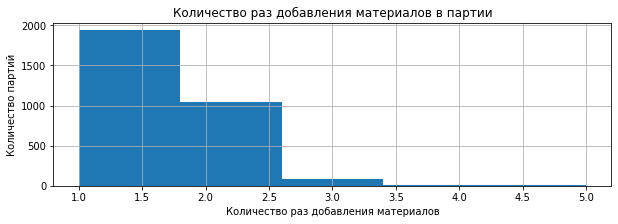

In [83]:
data_wire_time_new['итого_wire_time'].hist(bins= 5, figsize=(10,3))
plt.title('Количество раз добавления материалов в партии')
plt.xlabel("Количество раз добавления материалов")
plt.ylabel("Количество партий")
data_wire_time_new['итого_wire_time'].describe()

<AxesSubplot:>

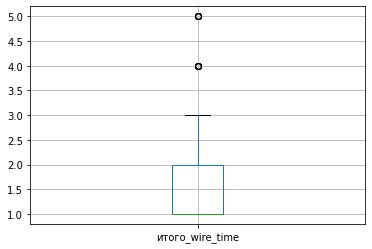

In [84]:
data_wire_time_new.boxplot(['итого_wire_time'])

Распределение данных по столбцу `итого_wire_time` аналогично распределению в таблице `data_wire_new['итого_wire_count']`.

На гистограмме столбца `wire_5` видно что данный материал применялся только дин раз за исследуемый период, как и по таблице `data_wire_new`. При выводе данных по данному столбцу данные в обоих таблицах коррелируются, что говорит о том что данные загружены корректно относительно этих двух датафреймов.

In [85]:
data_wire_new.sort_values(by='wire_5', ascending = False).head(1)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,итого_wire_count,итого_wire
2440,2567,18.30192,NaN,96.288193,NaN,15.132,73.307526,NaN,NaN,NaN,4,203.029639


In [86]:
data_wire_time_new.sort_values(by='wire_5', ascending = False).head(1)

,key,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,итого_wire_time
2440,2567,2019-08-13 07:10:14,NaT,2019-08-13 07:04:38,NaT,2019-08-13 06:14:30,2019-08-13 06:10:36,NaT,NaT,NaT,4


**Вывод по таблице `data_wire_time_new`:**  
Размерность датафрейма `data_wire_time_new` 3081 строк и 10 столбцов.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Дубликаты отсутствуют.  
Большое количество пропусков по столбцам `wire_1` - `wire_9`, аналогично таблице `data_wire_new`.

Добавлен столбец `итого_wire_time` в котором посчитано количество добавленных 
присадок по каждой партии.

Распределение данных по столбцу `итого_wire_time` аналогично распределению в 
таблице `data_wire_new['итого_wire_count']`, что говорит о том что данные загружены 
корректно относительно этих двух датафреймов.

Данные из таблицы `data_wire_time_new` я не планирую использовать при моделировании, поскольку 
уже есть данные по объемам добавленных материалов, точное время их добавления считаю ненужной 
и излишней информацией.

---

### **data_temp_new — результаты измерения температуры**
key — номер партии;  
Время замера — время замера;  
Температура — значение температуры.

Фиксируем размерность:

In [87]:
print('Номер первой партии:', data_temp_new['key'].min())
print('Номер последней партии:', data_temp_new['key'].max())
data_temp_new_sh1 = data_temp_new.shape
data_temp_new_sh1

Номер первой партии: 1
Номер последней партии: 3241


(18092, 3)

Приводим названия столбцов к стандарту:

In [88]:
rep_rec(data_temp_new)

,key,время_замера,температура
0,1,2019-05-03 11:02:04,1571.0
1,1,2019-05-03 11:07:18,1604.0
2,1,2019-05-03 11:11:34,1618.0
3,1,2019-05-03 11:18:04,1601.0
4,1,2019-05-03 11:25:59,1606.0
...,...,...,...
18087,3241,2019-09-06 16:55:01,NaN
18088,3241,2019-09-06 17:06:38,NaN
18089,3241,2019-09-06 17:21:48,NaN
18090,3241,2019-09-06 17:24:44,NaN


Выводим основные характеристики по датафрейму:

In [89]:
pred(data_temp_new)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18092 entries, 0 to 18091
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           18092 non-null  int64         
 1   время_замера  18092 non-null  datetime64[ns]
 2   температура   14665 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 424.2 KB


(None,
                 key   температура
 count  18092.000000  14665.000000
 mean    1616.460977   1590.722741
 std      934.641385     20.394381
 min        1.000000   1191.000000
 25%      807.750000   1580.000000
 50%     1618.000000   1590.000000
 75%     2429.000000   1599.000000
 max     3241.000000   1705.000000,
 0,
 key                0
 время_замера       0
 температура     3427
 dtype: int64)

array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'время_замера'}>],
       [<AxesSubplot:title={'center':'температура'}>, <AxesSubplot:>]],
      dtype=object)

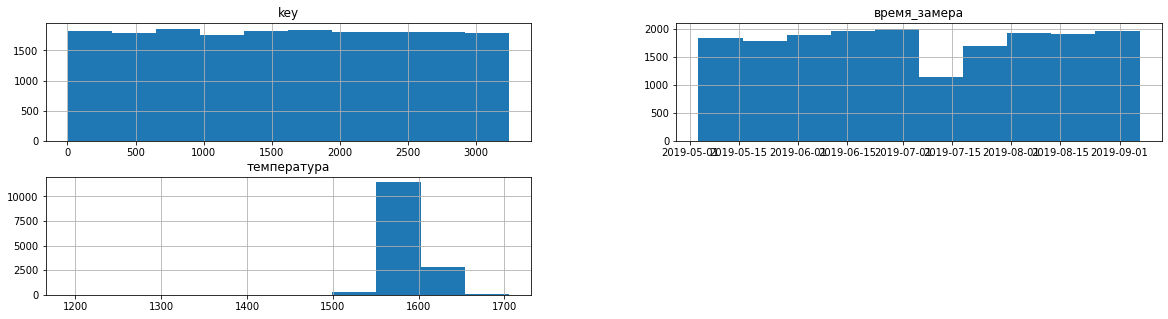

In [90]:
data_temp_new.hist(figsize=(20,5), grid = True)

**Типы данных присвоены верно, дубликаты отсутствуют, пропуски по столбцу `температура` в количестве  3427.**  
Странно выглядит снижение температруы до 1200 градусов в районе 2019-07.  
Построим график распределения температуры относительно времени.

<AxesSubplot:title={'center':'Изменение температуры ковша во времени'}, xlabel='время_замера'>

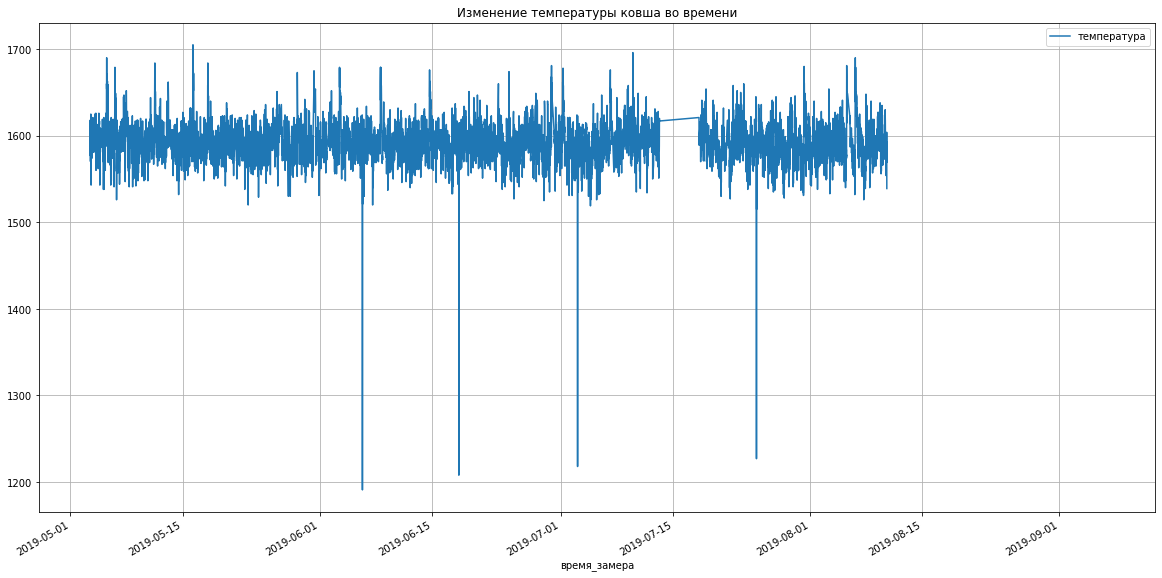

In [91]:
data_temp_new.plot(x = 'время_замера', y= 'температура', figsize=(20,10), grid = True,  
                   title = 'Изменение температуры ковша во времени',)

In [92]:
data_temp_new['month'] = data_temp_new['время_замера'].dt.month
data_temp_new['day'] = data_temp_new['время_замера'].dt.day
data_temp_new.query('month == 7 and day > 13 and day < 18')

,key,время_замера,температура,month,day


In [93]:
data_temp_new.query('month == 8 and day > 12')

,key,время_замера,температура,month,day
14313,2564,2019-08-13 00:39:45,NaN,8,13
14314,2564,2019-08-13 01:00:28,NaN,8,13
14315,2564,2019-08-13 01:05:44,NaN,8,13
14316,2564,2019-08-13 01:09:59,NaN,8,13
14317,2565,2019-08-13 01:10:59,1612.0,8,13
...,...,...,...,...,...
17185,3073,2019-08-31 23:34:47,NaN,8,31
17186,3073,2019-08-31 23:40:32,NaN,8,31
17187,3073,2019-08-31 23:43:29,NaN,8,31
17188,3073,2019-08-31 23:49:53,NaN,8,31


**Как видно по графику, у нас имеет место два вида аномалий:**  
- падение температуры примерно до 1250
- пропуски в замерах температры в период с 2019-07-14 по 2019-07-17 и с 2019-08-13 до конца исследуемого периода.  

**Поскольку объектом моделирования является температура ковша перед выплавкой, мы не можем использовать ковши по которым нет данных, данные партии придется удалить полностью из всех датафреймов.**   
Появление пропусков может быть связано с некорректной выгрузкой данных, потому что по другим параметрам, например перемешивание газом или добавление bulk и wire, данные по мощности не имеют такого количества пропусков по строке.  Возможно данные по температуре отсутствуют из-за сбоя в оборудовании в момент плавки стали.

Создадим список партий стали которые содержат нулевые значения и используем его для удаления некорректных данных

In [94]:
data_2 = data_temp_new.fillna(0)
zer = data_2.query('температура == 0').groupby('key')['температура'].sum().index.tolist()
zer

[2500,
 2501,
 2502,
 2503,
 2504,
 2505,
 2506,
 2507,
 2508,
 2509,
 2510,
 2511,
 2512,
 2513,
 2514,
 2515,
 2516,
 2517,
 2518,
 2519,
 2520,
 2521,
 2522,
 2523,
 2524,
 2525,
 2526,
 2527,
 2528,
 2529,
 2530,
 2531,
 2532,
 2533,
 2534,
 2535,
 2536,
 2537,
 2538,
 2539,
 2540,
 2541,
 2542,
 2543,
 2544,
 2545,
 2546,
 2547,
 2548,
 2549,
 2550,
 2551,
 2552,
 2553,
 2554,
 2555,
 2556,
 2557,
 2558,
 2559,
 2560,
 2561,
 2562,
 2563,
 2564,
 2565,
 2566,
 2567,
 2568,
 2569,
 2570,
 2571,
 2572,
 2573,
 2574,
 2575,
 2576,
 2577,
 2578,
 2579,
 2580,
 2581,
 2582,
 2583,
 2584,
 2585,
 2586,
 2587,
 2588,
 2589,
 2590,
 2591,
 2592,
 2593,
 2594,
 2595,
 2596,
 2597,
 2598,
 2599,
 2600,
 2601,
 2602,
 2603,
 2604,
 2605,
 2606,
 2607,
 2608,
 2609,
 2610,
 2611,
 2612,
 2613,
 2614,
 2615,
 2616,
 2617,
 2618,
 2619,
 2620,
 2621,
 2622,
 2623,
 2624,
 2625,
 2626,
 2627,
 2628,
 2629,
 2630,
 2631,
 2632,
 2633,
 2634,
 2635,
 2636,
 2637,
 2638,
 2639,
 2640,
 2641,
 2642,

In [95]:
data_temp_new = data_temp_new[data_temp_new.key.isin (zer) == False]

Проверим удаление:

In [96]:
data_temp_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13926 entries, 0 to 13925
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13926 non-null  int64         
 1   время_замера  13926 non-null  datetime64[ns]
 2   температура   13926 non-null  float64       
 3   month         13926 non-null  int64         
 4   day           13926 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 652.8 KB


In [97]:
data_temp_new.loc[data_temp_new['key'] == 2567]

,key,время_замера,температура,month,day


Построим ящик с усами чтобы определить выбросы по температуре:

<AxesSubplot:>

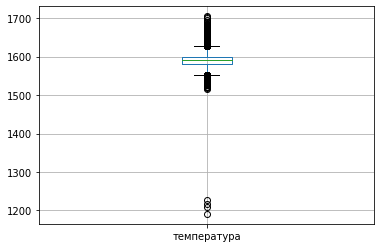

In [98]:
data_temp_new.boxplot(['температура'])

In [99]:
data_temp_new.sort_values(by='температура').head(10)

,key,время_замера,температура,month,day
4883,867,2019-06-06 08:03:39,1191.0,6,6
6784,1214,2019-06-18 08:01:03,1208.0,6,18
9050,1619,2019-07-03 02:34:41,1218.0,7,3
11495,2052,2019-07-25 08:49:15,1227.0,7,25
11499,2052,2019-07-25 09:20:11,1515.0,7,25
9359,1671,2019-07-04 17:02:03,1519.0,7,4
2881,512,2019-05-23 02:49:33,1520.0,5,23
5117,908,2019-06-07 14:32:37,1520.0,6,7
4889,867,2019-06-06 08:43:02,1521.0,6,6
4888,867,2019-06-06 08:36:49,1522.0,6,6


Согласно информации температура плавления стали 1450-1520°C, таким образом все что ниже 1400 просто застынет и производственный процес будет остановлен. Поэтому все ковши у которых зафиксированна температура ниже 1400 я удалю как аномалии. 

In [100]:
data_temp_new = data_temp_new.loc[data_temp_new['температура'] > 1500]
data_temp_new.sort_values(by='температура').head(10)

,key,время_замера,температура,month,day
11499,2052,2019-07-25 09:20:11,1515.0,7,25
9359,1671,2019-07-04 17:02:03,1519.0,7,4
2881,512,2019-05-23 02:49:33,1520.0,5,23
5117,908,2019-06-07 14:32:37,1520.0,6,7
4889,867,2019-06-06 08:43:02,1521.0,6,6
4888,867,2019-06-06 08:36:49,1522.0,6,6
8402,1503,2019-06-28 22:15:01,1525.0,6,28
8401,1503,2019-06-28 22:07:29,1525.0,6,28
489,88,2019-05-06 17:48:51,1526.0,5,6
9365,1672,2019-07-04 17:44:27,1526.0,7,4


Посмотрим как изменились характеристики данных:

In [101]:
pred(data_temp_new)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13922 entries, 0 to 13925
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   key           13922 non-null  int64         
 1   время_замера  13922 non-null  datetime64[ns]
 2   температура   13922 non-null  float64       
 3   month         13922 non-null  int64         
 4   day           13922 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 652.6 KB


(None,
                 key   температура         month           day
 count  13922.000000  13922.000000  13922.000000  13922.000000
 mean    1243.474573   1590.911794      6.182301     14.960422
 std      719.183183     18.773405      0.971667      9.155683
 min        1.000000   1515.000000      5.000000      1.000000
 25%      624.000000   1580.000000      5.000000      7.000000
 50%     1246.000000   1590.000000      6.000000     14.000000
 75%     1870.000000   1599.000000      7.000000     23.000000
 max     2499.000000   1705.000000      8.000000     31.000000,
 0,
 key             0
 время_замера    0
 температура     0
 month           0
 day             0
 dtype: int64)

<AxesSubplot:title={'center':'Изменение температуры ковша во времени'}, xlabel='время_замера'>

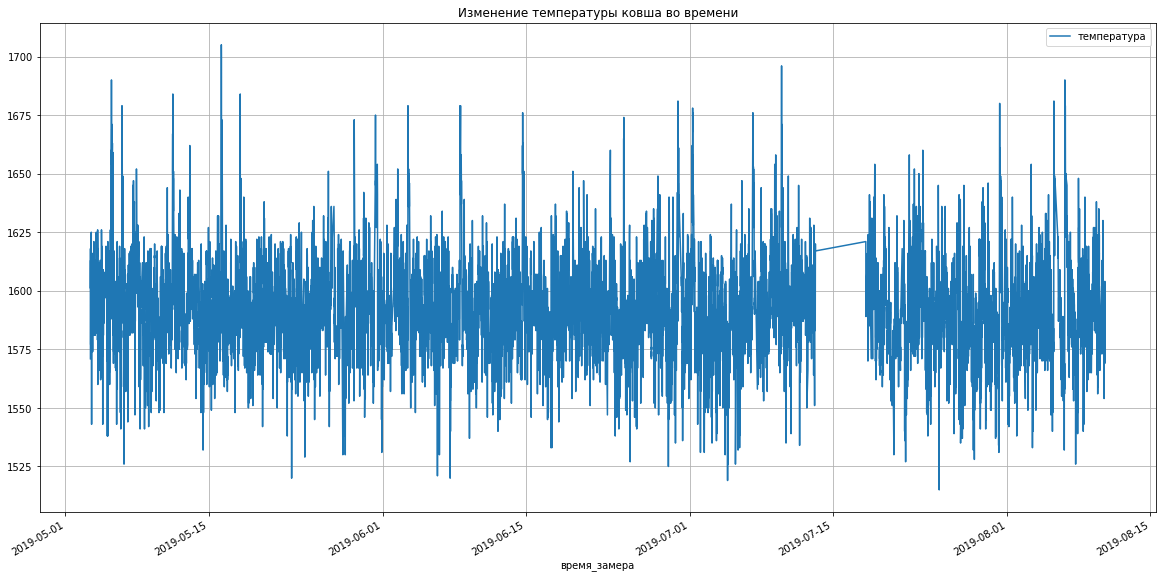

In [102]:
data_temp_new.plot(x = 'время_замера', y= 'температура', figsize=(20,10), grid = True,  
                   title = 'Изменение температуры ковша во времени',)

Начало периода 2019-05-03 11:02:04
Конец периода 2019-08-10 13:58:58


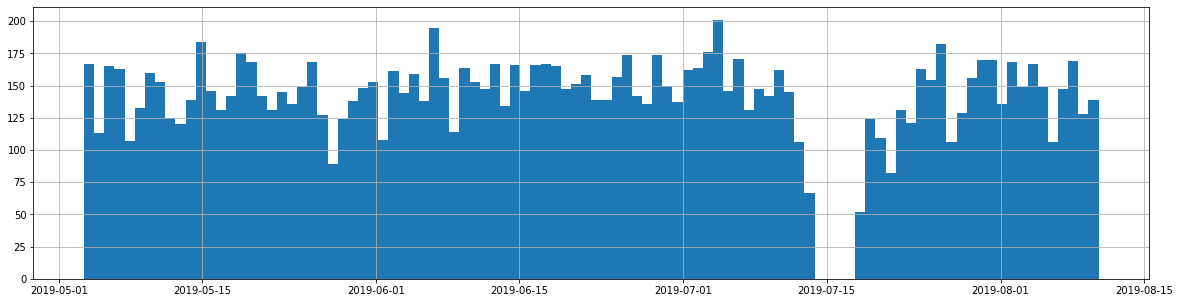

In [103]:
data_temp_new['время_замера'].hist(bins = 100, figsize=(20,5))
print('Начало периода', data_temp_new['время_замера'].min())
print('Конец периода', data_temp_new['время_замера'].max())

Пропускии аномалии удалены, можно двигаться дальше.  
Для целей данного проекта нам нужно спрогнозировать последнюю температуру ковша перед разливом в слябы, а также нам нужна первая температура, когда сплав только поместили в ковш, как парамерт. Промежуточные температуры нам не понядобятся.  
Для того чтобы получить эти данные агрегируем таблицу `data_temp_new` по первой и последней температуре и по каждому ковшу.

In [104]:
data_3 = data_temp_new.pivot_table(index = 'key', values = ('температура'), aggfunc = ('first', 'last'))
data_3.reset_index(inplace= True )
data_3

,key,first,last
0,1,1571.0,1613.0
1,2,1581.0,1602.0
2,3,1596.0,1599.0
3,4,1601.0,1625.0
4,5,1576.0,1602.0
...,...,...,...
2472,2495,1570.0,1591.0
2473,2496,1554.0,1591.0
2474,2497,1571.0,1589.0
2475,2498,1591.0,1594.0


**Вывод по таблице `data_temp_new`:**  
Размерность датафрейма `data_temp_new` 18092 строки и 3 столбца.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Дубликаты отсутствуют.  
Большое количество пропусков по столбцу `температура`.

**В данных были выявлены два вида аномалий:**  
- падение температуры ниже 1400
- пропуски по столбцу `температура` в период с 2019-07-14 по 2019-07-17 и с 2019-08-13 до конца исследуемого периода. 

Поскольку объектом моделирования является температура ковша перед выплавкой, 
мы не можем использовать ковши по которым нет данных, данные партии были удалиены полностью.  

Появление пропусков может быть связано с некорректной выгрузкой данных, 
потому что по другим параметрам, например перемешивание газом или добавление bulk и wire, 
данные по мощности не имеют такого количества пропусков по строке.  
Возможно данные по температуре отсутствуют из-за сбоя в оборудовании в момент плавки стали.

Также были удалены аномалии относительно чрезвычайно низких температур, поскольку температура плавления стали 1450-1520°C.  
Из данных были удалены ковши где была зафиксирована температура ниже 1400.

По итогу предобработки создан датафрейм `data_3`, который включает сгруппированные по ковшу данные: первая и последняя температуры.  
Промежуточные температуры и время нам не понадобятся для моделирования.


---

## Объединение данных

Для моделирования были подготовлены следующие таблицы: `data_1`(data_arc_new), `data_bulk_new`, `data_gas_new`, `data_wire_new`,`data_3`(data_temp_new).  

Объединенять планирую таблицу `data_3`(data_temp_new) с другими таблицами по столбцу `key`. 

In [105]:
pd.options.display.max_columns = None

In [106]:
result = pd.merge(data_3, data_1, how="inner", on=['key'])
result1 = pd.merge(result, data_gas_new, how="inner", on=['key'])
result2 = pd.merge(result1, data_bulk_new, how="inner", on=['key'])
result3 = pd.merge(result2, data_wire_new, how="inner", on=['key'])
result3

,key,first,last,полная_мощность,рабочее_время,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_count,итого_bulk,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,итого_wire_count,итого_wire
0,1,1571.0,1613.0,1.526725,1098.0,29.749986,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0,4,553.0,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,60.059998
1,2,1581.0,1602.0,0.978428,811.0,12.555561,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0,4,582.0,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,96.052315
2,3,1596.0,1599.0,2.878388,655.0,28.554793,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0,4,544.0,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,91.160157
3,4,1601.0,1625.0,1.607567,741.0,18.841219,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0,4,595.0,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,89.063515
4,5,1576.0,1602.0,1.123995,869.0,5.413692,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0,4,584.0,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,98.352796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2495,1570.0,1591.0,2.001960,723.0,7.125735,NaN,NaN,21.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,NaN,256.0,NaN,129.0,223.0,5,719.0,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,89.150879
2324,2496,1554.0,1591.0,2.842456,940.0,9.412616,NaN,NaN,NaN,63.0,NaN,NaN,NaN,NaN,NaN,122.0,NaN,256.0,NaN,129.0,226.0,5,796.0,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,114.179527
2325,2497,1571.0,1589.0,3.195647,569.0,6.271699,NaN,NaN,NaN,85.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,230.0,NaN,124.0,226.0,4,665.0,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,103.134723
2326,2498,1591.0,1594.0,1.731759,750.0,14.953657,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,101.0,NaN,206.0,NaN,129.0,207.0,5,733.0,118.110717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,118.110717


In [107]:
result3_sh1 = result3.shape
result3_sh1

(2328, 34)

---

## Исследовательский анализ и предобработка данных объединённого датафрейма

Посмотрим характеристики новой таблицы:

In [108]:
result3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2328 entries, 0 to 2327
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   key               2328 non-null   int64  
 1   first             2328 non-null   float64
 2   last              2328 non-null   float64
 3   полная_мощность   2328 non-null   float64
 4   рабочее_время     2328 non-null   float64
 5   газ_1             2328 non-null   float64
 6   bulk_1            199 non-null    float64
 7   bulk_2            13 non-null     float64
 8   bulk_3            960 non-null    float64
 9   bulk_4            812 non-null    float64
 10  bulk_5            53 non-null     float64
 11  bulk_6            437 non-null    float64
 12  bulk_7            13 non-null     float64
 13  bulk_8            1 non-null      float64
 14  bulk_9            13 non-null     float64
 15  bulk_10           143 non-null    float64
 16  bulk_11           130 non-null    float64


array([[<AxesSubplot:title={'center':'key'}>,
        <AxesSubplot:title={'center':'first'}>,
        <AxesSubplot:title={'center':'last'}>,
        <AxesSubplot:title={'center':'полная_мощность'}>,
        <AxesSubplot:title={'center':'рабочее_время'}>,
        <AxesSubplot:title={'center':'газ_1'}>],
       [<AxesSubplot:title={'center':'bulk_1'}>,
        <AxesSubplot:title={'center':'bulk_2'}>,
        <AxesSubplot:title={'center':'bulk_3'}>,
        <AxesSubplot:title={'center':'bulk_4'}>,
        <AxesSubplot:title={'center':'bulk_5'}>,
        <AxesSubplot:title={'center':'bulk_6'}>],
       [<AxesSubplot:title={'center':'bulk_7'}>,
        <AxesSubplot:title={'center':'bulk_8'}>,
        <AxesSubplot:title={'center':'bulk_9'}>,
        <AxesSubplot:title={'center':'bulk_10'}>,
        <AxesSubplot:title={'center':'bulk_11'}>,
        <AxesSubplot:title={'center':'bulk_12'}>],
       [<AxesSubplot:title={'center':'bulk_13'}>,
        <AxesSubplot:title={'center':'bulk_14'}>,
   

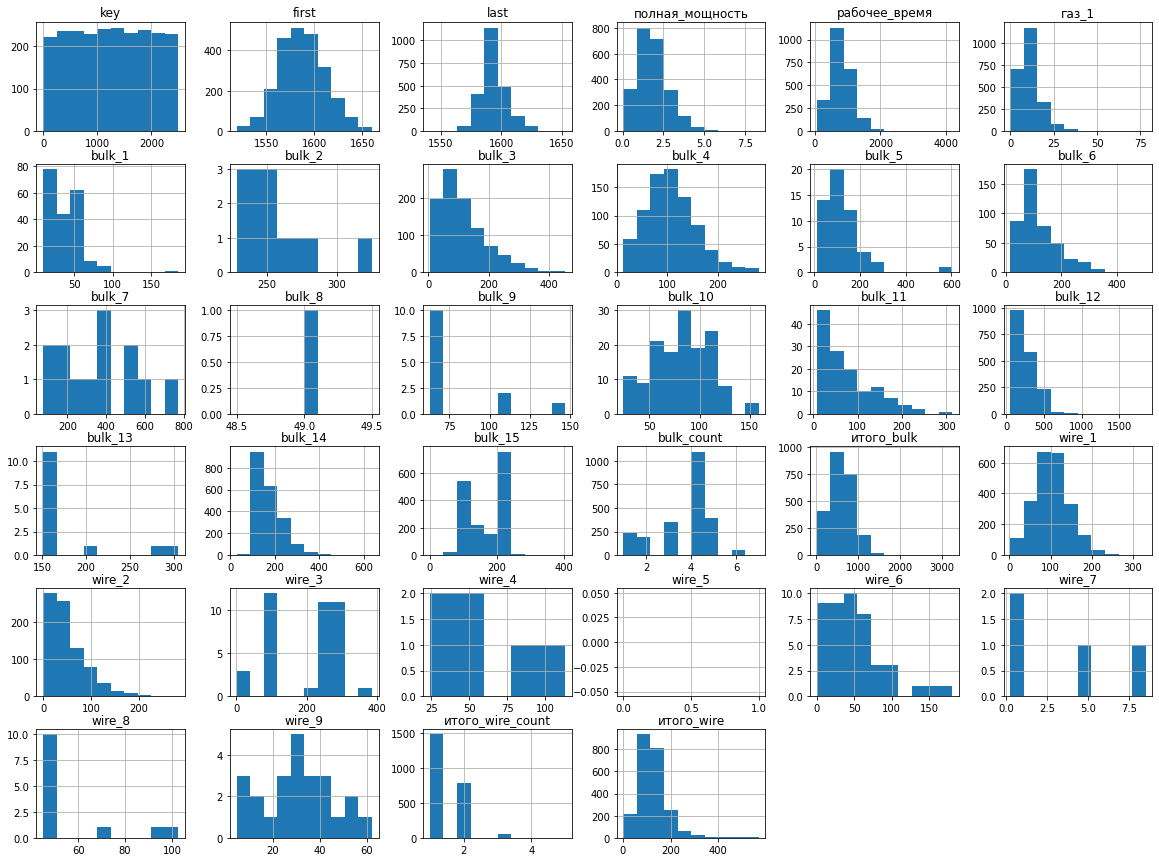

In [109]:
result3.hist(figsize = (20, 15))

In [110]:
result3.isna().sum()

key                    0
first                  0
last                   0
полная_мощность        0
рабочее_время          0
газ_1                  0
bulk_1              2129
bulk_2              2315
bulk_3              1368
bulk_4              1516
bulk_5              2275
bulk_6              1891
bulk_7              2315
bulk_8              2327
bulk_9              2315
bulk_10             2185
bulk_11             2198
bulk_12              516
bulk_13             2314
bulk_14              261
bulk_15              629
bulk_count             0
итого_bulk             0
wire_1                23
wire_2              1517
wire_3              2289
wire_4              2316
wire_5              2328
wire_6              2283
wire_7              2324
wire_8              2315
wire_9              2304
итого_wire_count       0
итого_wire             0
dtype: int64

**План действий для дальнейшей обработки:**
- Добавлю столбец `итого_добавлено`, в котором зафиксируем какое количество раз в сплав добавляли новые материалы, так можно будет выявить аномалию, а также это можно соотнести с количество использованного газа.
- Также заменю пропуски на "0", чтобы было удобнее смотреть данные. 
- Посмотрим на столбцы в которых есть пропуски (bulk и wire).
- Проверим корреляцию в датафрейме.

In [111]:
result3 = result3.fillna(0)
result3['итого_добавлено'] = result3['bulk_count'] + result3['итого_wire_count']

In [112]:
result3

,key,first,last,полная_мощность,рабочее_время,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_count,итого_bulk,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,итого_wire_count,итого_wire,итого_добавлено
0,1,1571.0,1613.0,1.526725,1098.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,4,553.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,60.059998,5
1,2,1581.0,1602.0,0.978428,811.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,4,582.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,96.052315,5
2,3,1596.0,1599.0,2.878388,655.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,4,544.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,91.160157,5
3,4,1601.0,1625.0,1.607567,741.0,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,4,595.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,89.063515,5
4,5,1576.0,1602.0,1.123995,869.0,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,4,584.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,98.352796,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,2495,1570.0,1591.0,2.001960,723.0,7.125735,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,5,719.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,89.150879,6
2324,2496,1554.0,1591.0,2.842456,940.0,9.412616,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,5,796.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,114.179527,6
2325,2497,1571.0,1589.0,3.195647,569.0,6.271699,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,4,665.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2,103.134723,6
2326,2498,1591.0,1594.0,1.731759,750.0,14.953657,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,5,733.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,118.110717,6


**Теперь посмотрим еще раз на аномалии по столбцам**

Согласно графиков по столбцам можно считать выбросами значения:  
`полная_мощность` - выбросы в данных есть но если посмотреть на взаимосвязь между данными, видно что для большей мощности характерны и более высокие данные по затраченному времени на разогрев и количество раз легирования.  
`рабочее_время` - аналогично предыдущему пункту, выброс есть на уровне 4000, но он коррелируется с максимальной полной мощностью, при количество легирования выше среднего.   
`газ_1` - аналогично первому пункту, выброс есть на уровне 80, но он коррелируется с высокой полной мощностью и высоким количеством раз легирования.   

Чтобы модель хорошо работала на новых данных в бизнесе, я думаю что датафрейм не стоит сильно чистить и делать его синтетическими, поскольку модель не будет знать как действовать в нестандартных ситуациях.  
**Ошибоки не выявленны, корректировать данные не буду.**

<AxesSubplot:title={'center':'Зависимость количества рабочего времени от затраченной полной мощности'}, xlabel='полная_мощность', ylabel='рабочее_время'>

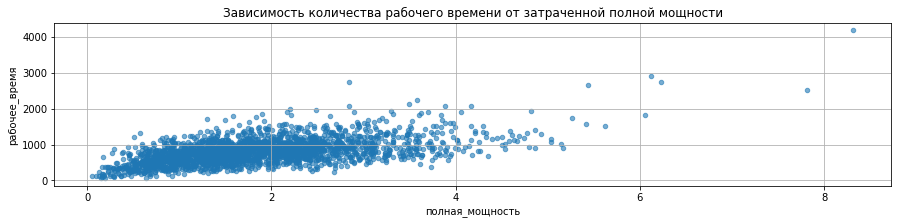

In [113]:
result3.plot(
    x = 'полная_мощность', y = 'рабочее_время', 
    title = 'Зависимость количества рабочего времени от затраченной полной мощности', 
    kind = 'scatter', alpha = 0.6, figsize = (15, 3), grid = True)

<AxesSubplot:title={'center':'Зависимость затраченной полной мощности от количества раз легирования стали'}, xlabel='полная_мощность', ylabel='итого_добавлено'>

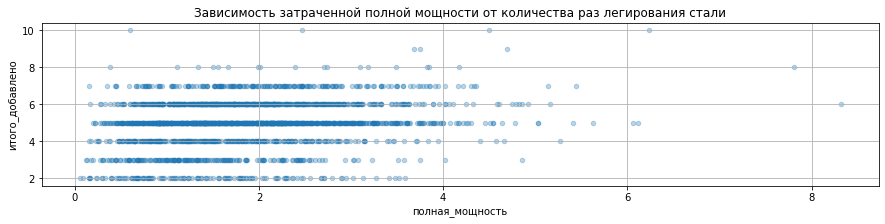

In [114]:
result3.plot(
    x = 'полная_мощность', y = 'итого_добавлено', 
    title = 'Зависимость затраченной полной мощности от количества раз легирования стали', 
    kind = 'scatter', alpha = 0.3, figsize = (15, 3), grid = True)

<AxesSubplot:title={'center':'Зависимость количества рабочего времени от количества раз легирования стали'}, xlabel='итого_добавлено', ylabel='рабочее_время'>

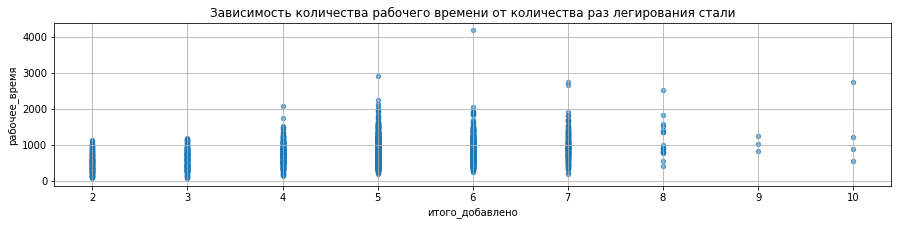

In [115]:
result3.plot(
    x = 'итого_добавлено', y = 'рабочее_время', 
    title = 'Зависимость количества рабочего времени от количества раз легирования стали', 
    kind = 'scatter', alpha = 0.6, figsize = (15, 3), grid = True)

<AxesSubplot:title={'center':'Зависимость количества добавленного газа от затраченной полной мощности'}, xlabel='полная_мощность', ylabel='газ_1'>

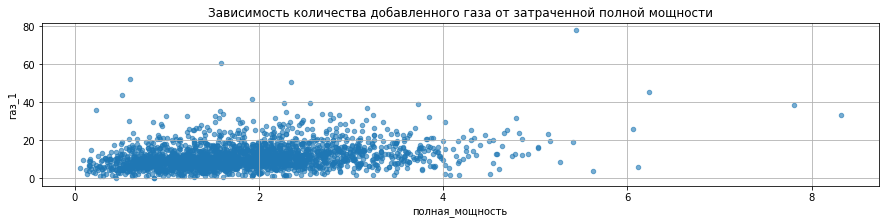

In [116]:
result3.plot(
    x = 'полная_мощность', y = 'газ_1', 
    title = 'Зависимость количества добавленного газа от затраченной полной мощности', 
    kind = 'scatter', alpha = 0.6, figsize = (15, 3), grid = True)

<AxesSubplot:title={'center':'Зависимость количества добавленного газа от количества раз легирования стали'}, xlabel='итого_добавлено', ylabel='газ_1'>

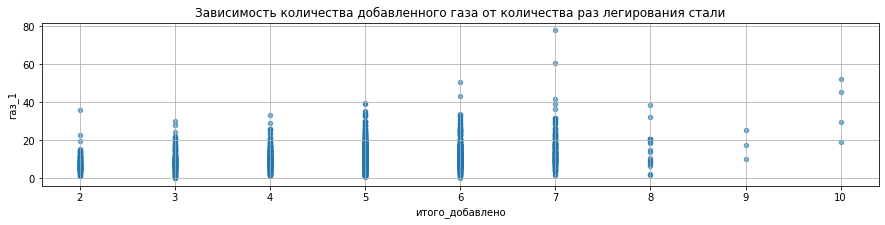

In [117]:
result3.plot(
    x = 'итого_добавлено', y = 'газ_1', 
    title = 'Зависимость количества добавленного газа от количества раз легирования стали', 
    kind = 'scatter', alpha = 0.6, figsize = (15, 3), grid = True)

<AxesSubplot:>

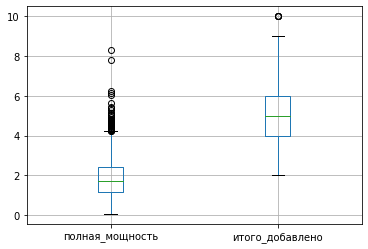

In [118]:
result3.boxplot(['полная_мощность', 'итого_добавлено'])

<AxesSubplot:>

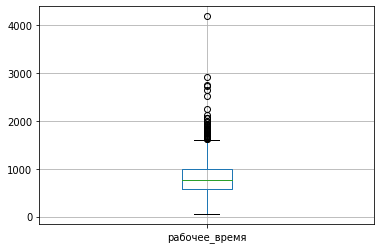

In [119]:
result3.boxplot(['рабочее_время'])

<AxesSubplot:>

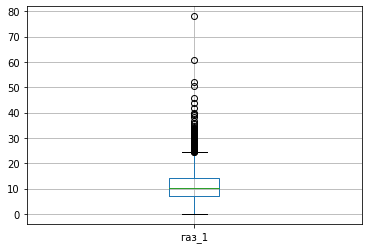

In [120]:
result3.boxplot(['газ_1'])

**Теперь переходим к проверки корреляции между столбцами**

In [121]:
corr = result3.corr()
corr = corr.replace({0:1, 1:0})
corr

,key,first,last,полная_мощность,рабочее_время,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_count,итого_bulk,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,итого_wire_count,итого_wire,итого_добавлено
key,0.000000,-0.015732,-0.096599,-0.010969,-0.028804,-0.043516,-0.078118,-0.006165,-0.006947,-0.025827,0.035284,0.005180,0.052393,0.015508,-0.039692,0.063021,0.035033,0.026666,-0.015763,-0.110598,-0.044828,0.026144,-0.025720,-0.013244,0.043437,-0.027219,0.049297,NaN,-0.008180,0.037029,-0.035970,0.021366,0.036158,0.003296,0.040177
first,-0.015732,0.000000,0.301241,-0.114298,-0.384900,0.036053,0.078792,0.141379,-0.114034,0.164858,0.078568,-0.127292,0.087653,-0.011752,-0.033433,0.035548,-0.110513,-0.080350,0.020156,-0.181010,-0.063286,-0.069813,-0.112233,0.262532,-0.100822,-0.003503,0.076014,NaN,0.020618,0.052747,-0.029871,0.002556,-0.058437,0.131464,-0.090793
last,-0.096599,0.301241,0.000000,0.138427,0.278112,0.059203,-0.075401,-0.082532,-0.036365,0.187687,-0.028436,-0.180843,-0.107357,-0.026610,-0.016124,0.061233,-0.114912,0.266851,-0.010969,0.114991,0.265801,0.108701,0.222228,0.317362,-0.207076,-0.047624,-0.159821,NaN,-0.084135,-0.137336,-0.010813,-0.027553,-0.201229,0.060630,0.014936
полная_мощность,-0.010969,-0.114298,0.138427,0.000000,0.560180,0.298570,0.085020,0.084125,0.081858,0.007436,0.064933,0.105641,0.128233,-0.029038,0.014649,0.006993,0.059961,0.226455,0.078154,0.231164,0.141956,0.233893,0.311567,0.116887,0.046543,0.048994,0.088781,NaN,0.055888,0.050444,0.021456,-0.018311,0.034308,0.140912,0.234320
рабочее_время,-0.028804,-0.384900,0.278112,0.560180,0.000000,0.396497,0.102925,0.038188,0.092347,-0.028640,0.013467,0.163067,0.084611,-0.011304,0.012917,-0.005147,0.078103,0.466359,0.129273,0.461740,0.295245,0.345420,0.551608,0.055142,0.054251,0.033353,0.054787,NaN,0.042246,0.027613,0.017846,-0.011631,0.028916,0.091538,0.336640
газ_1,-0.043516,0.036053,0.059203,0.298570,0.396497,0.000000,0.234148,0.217417,0.059641,0.017589,0.086904,0.139723,0.198312,0.004128,0.116578,-0.008504,0.042030,0.217433,0.049057,0.268898,0.043662,0.224124,0.314081,0.117331,0.104261,0.103384,0.145414,NaN,0.108091,0.078953,0.118069,0.014071,0.129974,0.215450,0.266545
bulk_1,-0.078118,0.078792,-0.075401,0.085020,0.102925,0.234148,0.000000,0.224696,-0.011704,0.041775,0.060417,-0.003389,0.237209,-0.005727,-0.019765,-0.023216,-0.037915,0.325742,-0.010288,0.207799,-0.000968,0.270734,0.323672,0.013609,-0.009292,0.020258,0.146296,NaN,0.148551,0.083441,-0.019544,0.011056,0.031401,0.044019,0.267633
bulk_2,-0.006165,0.141379,-0.082532,0.084125,0.038188,0.217417,0.224696,0.000000,-0.046912,0.040775,0.360300,-0.029945,0.679355,-0.001546,-0.005335,-0.018023,0.001473,-0.099043,-0.005595,-0.140944,-0.105784,0.048761,0.040137,-0.169512,-0.039077,0.223199,0.699342,NaN,0.558888,0.431737,-0.005276,-0.006845,0.283266,0.090629,0.168315
bulk_3,-0.006947,-0.114034,-0.036365,0.081858,0.092347,0.059641,-0.011704,-0.046912,0.000000,-0.295654,-0.006833,0.065904,-0.033500,0.020820,0.011319,-0.085260,-0.007497,0.018021,-0.013411,0.010920,-0.013250,0.158127,0.208544,0.039475,0.095595,0.005749,-0.040547,NaN,0.007083,-0.019458,0.004827,0.004596,0.057038,0.078448,0.173059
bulk_4,-0.025827,0.164858,0.187687,0.007436,-0.028640,0.017589,0.041775,0.040775,-0.295654,0.000000,0.028318,-0.251250,0.045879,-0.013193,-0.002959,-0.084821,-0.119592,0.105477,0.003189,-0.090467,0.101180,0.108223,0.135670,0.297471,-0.268325,-0.039254,0.034407,NaN,-0.011448,0.033823,0.007812,-0.058169,-0.220841,0.042977,0.006002


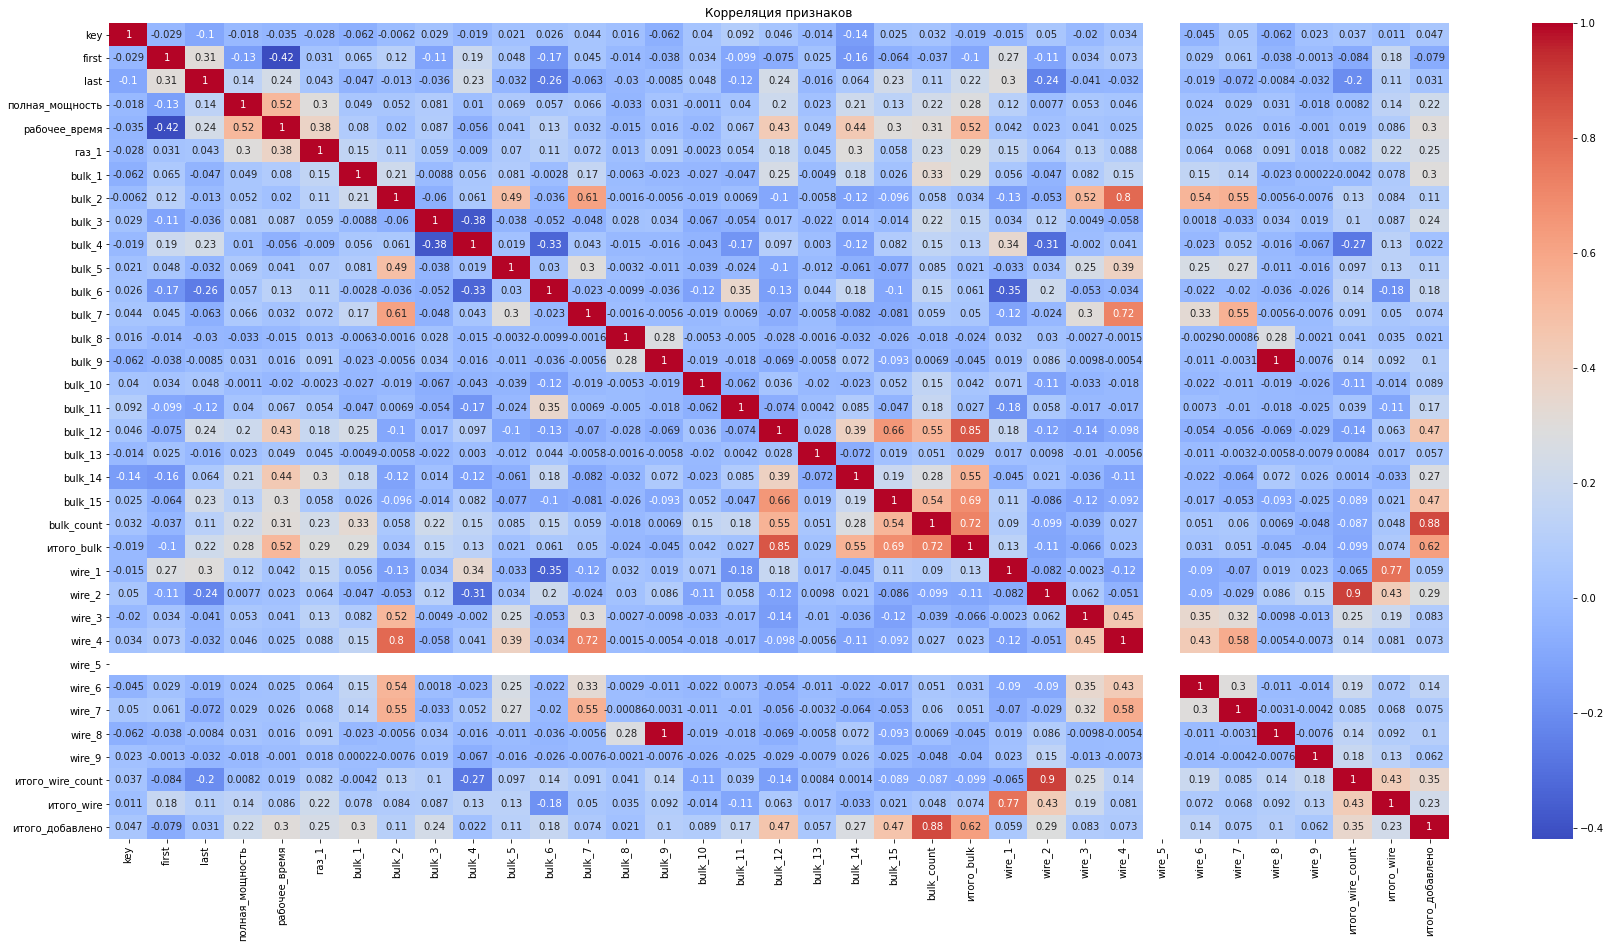

In [122]:
plt.figure(figsize=(30, 15))
plt.title('Корреляция признаков')
sns.heatmap(result3.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

In [123]:
corr['corr_column'] = corr.apply(lambda columns: columns[1 : 2499].max(),axis=0)
corr['corr_row'] = corr.apply(lambda row: row['first' : 'итого_добавлено'].sum(),axis=1)
corr = corr.query('corr_row >= 1').sort_values(by='corr_row')
corr#['corr_column']

,key,first,last,полная_мощность,рабочее_время,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_count,итого_bulk,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,итого_wire_count,итого_wire,итого_добавлено,corr_column,corr_row
wire_2,0.043437,-0.100822,-0.207076,0.046543,0.054251,0.104261,-0.009292,-0.039077,0.095595,-0.268325,-0.013822,0.205287,-0.000646,0.018909,0.066721,-0.103820,0.062028,-0.098605,-0.001407,0.036436,-0.096781,-0.082859,-0.067285,-0.068451,0.000000,0.094052,-0.033775,NaN,-0.058729,-0.016209,0.069260,0.213142,0.634087,0.528275,0.196596,0.634087,1.158462
wire_1,-0.013244,0.262532,0.317362,0.116887,0.055142,0.117331,0.013609,-0.169512,0.039475,0.297471,-0.013526,-0.235474,-0.143297,0.034647,0.022578,0.062654,-0.117816,0.169889,0.039422,-0.053698,0.118117,0.064630,0.108560,0.000000,-0.068451,0.038047,-0.142035,NaN,-0.128077,-0.067523,0.017216,0.021051,-0.065393,0.638296,0.032353,0.638296,1.382469
wire_3,-0.027219,-0.003503,-0.047624,0.048994,0.033353,0.103384,0.020258,0.223199,0.005749,-0.039254,0.070911,-0.046458,0.156623,-0.002401,-0.008286,-0.027989,-0.021839,-0.120581,-0.008688,-0.008833,-0.118198,-0.092193,-0.085066,0.038047,0.094052,0.000000,0.169807,NaN,0.183451,0.100391,-0.008193,-0.010630,0.336649,0.551426,0.059146,0.551426,1.545704
wire_8,-0.035970,-0.029871,-0.010813,0.021456,0.017846,0.118069,-0.019544,-0.005276,0.004827,0.007812,-0.008340,-0.028404,-0.004625,0.321039,0.974969,-0.017095,-0.013343,-0.055835,-0.005307,0.043676,-0.090029,0.014855,-0.029923,0.017216,0.069260,-0.008193,-0.004560,NaN,-0.007968,-0.002188,0.000000,-0.006493,0.185109,0.112103,0.094029,0.974969,1.654461
bulk_5,0.035284,0.078568,-0.028436,0.064933,0.013467,0.086904,0.060417,0.360300,-0.006833,0.028318,0.000000,-0.021768,0.288335,-0.002444,-0.008435,-0.028493,-0.015849,-0.072853,-0.008845,-0.065867,-0.067291,0.087285,0.052787,-0.013526,-0.013822,0.070911,0.262761,NaN,0.204815,0.172140,-0.008340,-0.010821,0.081739,0.061559,0.117271,0.360300,1.718884
bulk_9,-0.039692,-0.033433,-0.016124,0.014649,0.012917,0.116578,-0.019765,-0.005335,0.011319,-0.002959,-0.008435,-0.028725,-0.004677,0.488391,0.000000,-0.017288,-0.013494,-0.057768,-0.005367,0.038865,-0.093591,0.011790,-0.032870,0.022578,0.066721,-0.008286,-0.004611,NaN,-0.008058,-0.002213,0.974969,-0.006566,0.186516,0.112637,0.091763,0.974969,1.780128
wire_7,0.037029,0.052747,-0.137336,0.050444,0.027613,0.078953,0.083441,0.431737,-0.019458,0.033823,0.172140,-0.012421,0.372250,-0.000641,-0.002213,-0.007476,-0.005835,-0.041081,-0.002321,-0.058461,-0.043877,0.035543,0.031715,-0.067523,-0.016209,0.100391,0.602964,NaN,0.302741,0.000000,-0.002188,-0.002839,0.197472,0.078639,0.118792,0.602964,2.351525
bulk_15,-0.044828,-0.063286,0.265801,0.141956,0.295245,0.043662,-0.000968,-0.105784,-0.013250,0.101180,-0.067291,-0.108210,-0.090178,-0.029404,-0.093591,0.052138,-0.048382,0.614169,0.018521,0.265816,0.000000,0.634022,0.677878,0.118117,-0.096781,-0.118198,-0.091431,NaN,-0.032504,-0.043877,-0.090029,-0.037032,-0.124736,-0.041860,0.540973,0.677878,2.472687
wire_6,-0.008180,0.020618,-0.084135,0.055888,0.042246,0.108091,0.148551,0.558888,0.007083,-0.011448,0.204815,-0.020142,0.456099,-0.002335,-0.008058,-0.017812,0.008692,-0.042812,-0.008450,-0.052364,-0.032504,0.059683,0.054753,-0.128077,-0.058729,0.183451,0.445959,NaN,0.000000,0.302741,-0.007968,-0.010339,0.263944,0.131637,0.170204,0.558888,2.738168
bulk_1,-0.078118,0.078792,-0.075401,0.085020,0.102925,0.234148,0.000000,0.224696,-0.011704,0.041775,0.060417,-0.003389,0.237209,-0.005727,-0.019765,-0.023216,-0.037915,0.325742,-0.010288,0.207799,-0.000968,0.270734,0.323672,0.013609,-0.009292,0.020258,0.146296,NaN,0.148551,0.083441,-0.019544,0.011056,0.031401,0.044019,0.267633,0.325742,2.741984


Корреляция более 0,9 показывает наличие мультиколлинеарности, как ожидалось это проявилось по суммирующим столбцам:  `bulk_count` и `итого добавлено` - 0,9. 
При этом по столбцам `итого_wire_count` и `итого добавлено` корреляция всего 0,35.

По другим суммирующим столбцам:
- `итого_wire_count` и `итого_wire` корреляция 0,52
- `итого добавлено` и `итого_wire` корреляция 0,19
- `bulk_count` и `итого_bulk` корреляция 0,76 
- `итого добавлено` и `итого_bulk` корреляция 0,68

Также видна высокая корреляция между:
- `итого_bulk` и `bulk_12` (0,86) и `bulk_15` (0,67) 
- `итого_wire` и `wire_1` корреляция 0,63
- между `wire_8` и `bulk_9` (0,97).

Для того чтобы избавиться от мультиколлинеарности я удалю столбцы: `итого_wire_count`, `bulk_count`, `итого добавлено`, `итого_wire`,  `итого_bulk`.

Что касается пары  `wire_8` и `bulk_9` и  я удалю стобец по присадкам bulk, т.к. их больше, а влияние на данные у этих столбцов одинаковое.

При объединении, единственный ковш  в котором был `wire_5` №2567 был удален, т.к. в этом ковше отсутствовали данные по температуре, поэтому в итоговой таблице появились пропуски. Так данных больше нет, удалим весь столбец `wire_5`. 

Для целей обучения, номер партии не имеет знаачения, поэтому, столбец `key` также будет удален, а также обновлены индексы.

In [124]:
result3.query('wire_5 > 0')

,key,first,last,полная_мощность,рабочее_время,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_9,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,bulk_count,итого_bulk,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9,итого_wire_count,итого_wire,итого_добавлено


---

In [125]:
result_fin = result3.drop(['key', 'wire_5', 'итого_wire_count', 'bulk_count', 
                           'bulk_9','итого_wire',  'итого_bulk', 'итого_добавлено'], axis= 1)
result_fin.reset_index(drop= True , inplace= True )
result_fin

,first,last,полная_мощность,рабочее_время,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1571.0,1613.0,1.526725,1098.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,1602.0,0.978428,811.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,1599.0,2.878388,655.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
3,1601.0,1625.0,1.607567,741.0,18.841219,0.0,0.0,0.0,81.0,0.0,0.0,0.0,0.0,0.0,0.0,207.0,0.0,153.0,154.0,89.063515,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
4,1576.0,1602.0,1.123995,869.0,5.413692,0.0,0.0,0.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,203.0,0.0,151.0,152.0,89.238236,9.11456,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2323,1570.0,1591.0,2.001960,723.0,7.125735,0.0,0.0,21.0,0.0,0.0,0.0,0.0,0.0,90.0,0.0,256.0,0.0,129.0,223.0,89.150879,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2324,1554.0,1591.0,2.842456,940.0,9.412616,0.0,0.0,0.0,63.0,0.0,0.0,0.0,0.0,122.0,0.0,256.0,0.0,129.0,226.0,114.179527,0.00000,0.0,0.0,0.0,0.0,0.0,0.0
2325,1571.0,1589.0,3.195647,569.0,6.271699,0.0,0.0,0.0,85.0,0.0,0.0,0.0,0.0,0.0,0.0,230.0,0.0,124.0,226.0,94.086723,9.04800,0.0,0.0,0.0,0.0,0.0,0.0
2326,1591.0,1594.0,1.731759,750.0,14.953657,0.0,0.0,90.0,0.0,0.0,0.0,0.0,0.0,101.0,0.0,206.0,0.0,129.0,207.0,118.110717,0.00000,0.0,0.0,0.0,0.0,0.0,0.0


Посмотрим как сейчас выглядет хитмеп

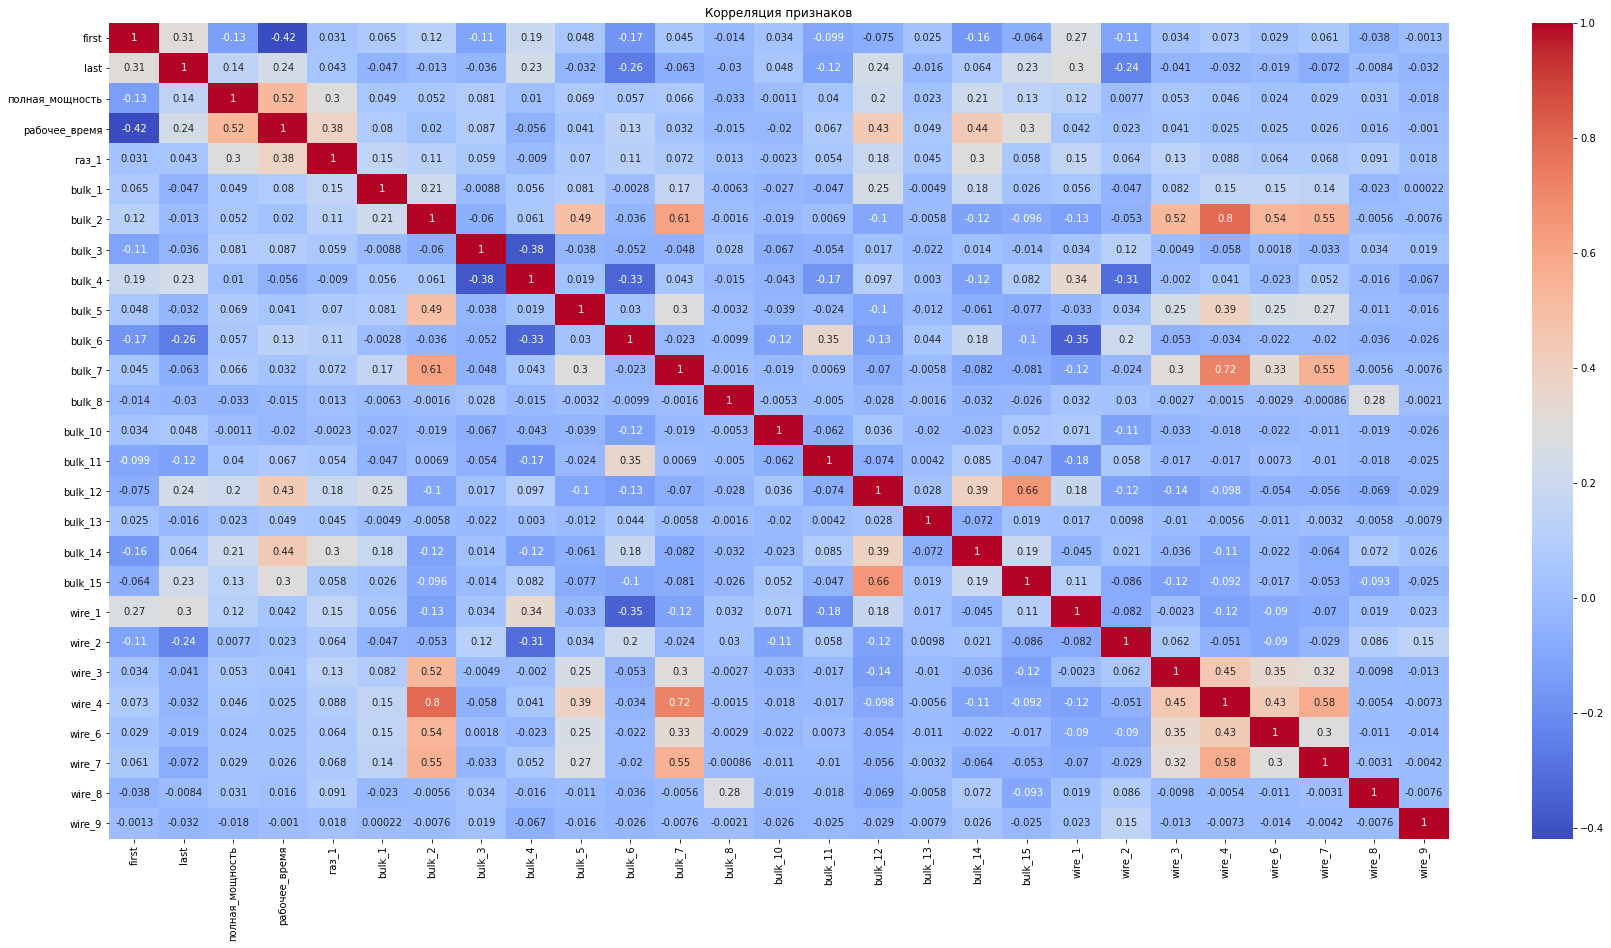

In [126]:
plt.figure(figsize=(30, 15))
plt.title('Корреляция признаков')
sns.heatmap(result_fin.corr(method='spearman'), annot = True, cmap="coolwarm")
plt.show()

**Проверим характеристики нового датафрейма:**

In [127]:
result_fin.isnull().sum()

first              0
last               0
полная_мощность    0
рабочее_время      0
газ_1              0
bulk_1             0
bulk_2             0
bulk_3             0
bulk_4             0
bulk_5             0
bulk_6             0
bulk_7             0
bulk_8             0
bulk_10            0
bulk_11            0
bulk_12            0
bulk_13            0
bulk_14            0
bulk_15            0
wire_1             0
wire_2             0
wire_3             0
wire_4             0
wire_6             0
wire_7             0
wire_8             0
wire_9             0
dtype: int64

In [128]:
result_fin.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2328 entries, 0 to 2327
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   first            2328 non-null   float64
 1   last             2328 non-null   float64
 2   полная_мощность  2328 non-null   float64
 3   рабочее_время    2328 non-null   float64
 4   газ_1            2328 non-null   float64
 5   bulk_1           2328 non-null   float64
 6   bulk_2           2328 non-null   float64
 7   bulk_3           2328 non-null   float64
 8   bulk_4           2328 non-null   float64
 9   bulk_5           2328 non-null   float64
 10  bulk_6           2328 non-null   float64
 11  bulk_7           2328 non-null   float64
 12  bulk_8           2328 non-null   float64
 13  bulk_10          2328 non-null   float64
 14  bulk_11          2328 non-null   float64
 15  bulk_12          2328 non-null   float64
 16  bulk_13          2328 non-null   float64
 17  bulk_14       

In [129]:
result_fin_fin = result_fin.shape
result_fin_fin

(2328, 27)

In [130]:
print(data_bulk_new_sh1[0], 'Размерность по таблицам bulk')
print(data_gas_new_sh1[0], 'Размерность по таблице gas')
print(data_wire_new_sh1[0], 'Размерность по таблицам wire')
print(result3_sh1[0], 'Размерность таблицы после объединения')
print(result_fin_fin[0], 'Размерность финальной таблицы')

3129 Размерность по таблицам bulk
3239 Размерность по таблице gas
3081 Размерность по таблицам wire
2328 Размерность таблицы после объединения
2328 Размерность финальной таблицы


In [131]:
print(1-(data_wire_new_sh1[0]-result_fin_fin[0])/data_wire_new_sh1[0], '-', 
      1-(data_gas_new_sh1[0]-result_fin_fin[0])/data_gas_new_sh1[0])

0.7555988315481986 - 0.7187403519604816


Получается что в результате предобрабтке было сохранено 75%- 72% от изначального объема выгруженых партий.

**Теперь данные можно подготавливать для обучения**

**Выводы по этапу Исследовательский анализ и предобработка данных объединённого датафрейма:**  

Финальный датафрейм по итогам предобработки составил 2328 строк и 27 столбца.  
Поле объединения, в датафрейме осталось много много пусков почти по всем столбцам.  
Пропуски были заменены  на "0", как корректная замена при отсутствии данных.  

Удален столбец `wire_5` в связи с отсутсвием данных.  

Проведена проверка на мультиколлинеарность: удалены столбцы `итого_wire_count`, `bulk_count` и `bulk_9`, `итого_wire`,  `итого_bulk` и `итого_добавлено`.  

Для целей обучения, номер партии не имеет значения, поэтому столбец `key` удален.  

По итогу объединения и предобработки итоговый файл был сохранен в размере 75%- 72% от изначального объема выгруженных партий. Индексы обновлены, старые удалены.

---

## Подготовка данных

Так как в датафрейме все признаки численные, кодирование не потребуется.  
В этом случае следующие этапы это:
- разделение датафрейма на признаки и целевой признак
- разделение датафреймов с признаками и целевым признаком на тренировочную и тестовые выборки
- масштабирование признаков.

**Разделяем датафрейм на признаки и целевой признак и выводим на экран**

In [132]:
target = result_fin['last']
features = result_fin.drop('last', axis=1)

In [133]:
target.head(3)

0    1613.0
1    1602.0
2    1599.0
Name: last, dtype: float64

In [134]:
features.head(3)

,first,полная_мощность,рабочее_время,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
0,1571.0,1.526725,1098.0,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1581.0,0.978428,811.0,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1596.0,2.878388,655.0,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Разделяю датафреймы с признаками и целевым признаком на тренировочную и тестовые выборки. Проверяем размерность.**

In [135]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state= 290124)

In [136]:
print(features_train.shape, target_train.shape, features_test.shape, target_test.shape)

(1746, 26) (1746,) (582, 26) (582,)


**Масштабируем признаки**

In [137]:
features_train.columns

Index(['first', 'полная_мощность', 'рабочее_время', 'газ_1', 'bulk_1',
       'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14', 'bulk_15',
       'wire_1', 'wire_2', 'wire_3', 'wire_4', 'wire_6', 'wire_7', 'wire_8',
       'wire_9'],
      dtype='object')

In [138]:
numeric = ['first', 'полная_мощность', 'рабочее_время', 'газ_1', 'bulk_1',
       'bulk_2', 'bulk_3', 'bulk_4', 'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8',
       'bulk_10', 'bulk_11', 'bulk_12', 'bulk_13', 'bulk_14',
       'bulk_15', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_6', 'wire_7', 'wire_8', 'wire_9']

pd.options.mode.chained_assignment = None
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [139]:
features_train.head(3)

,first,полная_мощность,рабочее_время,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
1172,-1.013810,-0.585117,0.471719,-0.245717,-0.286312,-0.079179,2.947317,-0.639314,-0.134279,-0.403564,-0.066606,0.0,-0.242851,-0.196123,1.620560,-0.074084,1.187772,0.992510,0.887880,-0.523263,-0.106704,-0.067302,-0.112591,-0.035725,-0.070956,-0.093358
2163,-0.256147,-0.653657,-0.201378,-0.382652,-0.286312,-0.079179,-0.631058,-0.639314,-0.134279,-0.403564,-0.066606,0.0,-0.242851,-0.196123,-0.329005,-0.074084,-0.075223,-0.197449,0.118569,-0.523263,-0.106704,-0.067302,-0.112591,-0.035725,-0.070956,-0.093358
326,0.669887,-0.282031,-0.670414,-0.275913,-0.286312,-0.079179,-0.631058,1.860285,-0.134279,-0.403564,-0.066606,0.0,-0.242851,-0.196123,-0.643451,-0.074084,-0.295940,1.004292,2.206730,-0.523263,-0.106704,-0.067302,-0.112591,-0.035725,-0.070956,-0.093358


In [140]:
features_test.head(3)

,first,полная_мощность,рабочее_время,газ_1,bulk_1,bulk_2,bulk_3,bulk_4,bulk_5,bulk_6,bulk_7,bulk_8,bulk_10,bulk_11,bulk_12,bulk_13,bulk_14,bulk_15,wire_1,wire_2,wire_3,wire_4,wire_6,wire_7,wire_8,wire_9
2312,0.459425,0.000304,-0.944526,2.411055,-0.286312,-0.079179,-0.631058,0.815932,-0.134279,-0.403564,-0.066606,0.0,-0.242851,-0.196123,-0.020848,-0.074084,-0.553444,-0.185668,0.419439,-0.224354,-0.106704,-0.067302,-0.112591,-0.035725,-0.070956,-0.093358
1303,0.838256,2.836402,0.514358,-1.397270,-0.286312,-0.079179,-0.631058,-0.639314,-0.134279,-0.403564,-0.066606,0.0,-0.242851,-0.196123,-0.020848,-0.074084,-0.614755,-0.197449,0.191971,1.862640,-0.106704,-0.067302,-0.112591,-0.035725,-0.070956,-0.093358
60,0.080593,0.415747,0.063597,0.402825,3.298321,-0.079179,-0.631058,2.288299,-0.134279,-0.403564,-0.066606,0.0,-0.242851,-0.196123,1.280958,-0.074084,0.292640,1.004292,2.080327,-0.253671,-0.106704,-0.067302,-0.112591,-0.035725,-0.070956,-0.093358


**Итого: данные подготовлены для дальнейшей работы.**

---

## Обучение моделей машинного обучения

**Целевая метрика МАЕ <= 6,8.**

### Линейная регрессия

In [141]:
model_lr = LinearRegression()
model_lr.fit(features_train, target_train)

LinearRegression()

In [142]:
scores = cross_val_score(model_lr, features_train, target_train, scoring='neg_mean_absolute_error', cv=5)
mae_lr = abs(scores.mean())
print('Метрика MAE по модели Линейной регрессии:', mae_lr.round(2))

Метрика MAE по модели Линейной регрессии: 6.94


### Случайный лес

In [143]:
param_grid = {
    'n_estimators': [80, 100, 120],
    'max_depth': [25, 30, 35],
    'random_state': [290124]}

In [144]:
rf_model = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf_model, param_grid = param_grid, cv=8, 
                           scoring = 'neg_mean_absolute_error', verbose = 0, refit=True)
grid_search.fit(features_train, target_train)

print('Лучшие параметры по модели Случайный лес:', grid_search.best_params_)
print('Метрика MAE по модели Случайный лес:', abs(grid_search.best_score_))

Лучшие параметры по модели Случайный лес: {'max_depth': 30, 'n_estimators': 120, 'random_state': 290124}
Метрика MAE по модели Случайный лес: 6.188671786255773


### CatBoost

In [145]:
params = {'iterations': [1500],
          'depth': [4, 5, 6, 7],
          'loss_function': ['MAE'],
          'l2_leaf_reg': np.logspace(-20, -19, 3),
          'logging_level':['Silent'],
          'random_state': [290124]}

In [146]:
cbr_model = CatBoostRegressor()
cbr_grid = GridSearchCV(estimator=cbr_model, param_grid=params, cv=5,
                       scoring = 'neg_mean_absolute_error', verbose = 0, refit=True, error_score='raise')
cbr_grid.fit(features_train, target_train)

print('Лучшие параметры по модели CatBoost:', cbr_grid.best_params_)
print('Метрика MAE по модели CatBoost:', abs(cbr_grid.best_score_))

Лучшие параметры по модели CatBoost: {'depth': 4, 'iterations': 1500, 'l2_leaf_reg': 1e-20, 'logging_level': 'Silent', 'loss_function': 'MAE', 'random_state': 290124}
Метрика MAE по модели CatBoost: 6.185163049441513


---

## Выбор лучшей модели

Построим таблицу для сведения итогов обучения моделей

In [147]:
index = ['Линейная регрессия',
         'Случайный лес',
         'CatBoost']
data = {'MAE на валидации':[ mae_lr.round(4),
                           abs(grid_search.best_score_).round(4),
                           abs(cbr_grid.best_score_).round(4)]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Задача решена'] = scores_data['MAE на валидации'] <6.8
scores_data

,MAE на валидации,Задача решена
Линейная регрессия,6.9410,False
Случайный лес,6.1887,True
CatBoost,6.1852,True


**Наилучший результат показала модель CatBoost.**

In [148]:
print('Лучшие параметры по модели CatBoost:', cbr_grid.best_params_)
print('Метрика MAE по модели CatBoost:', abs(cbr_grid.best_score_))

Лучшие параметры по модели CatBoost: {'depth': 4, 'iterations': 1500, 'l2_leaf_reg': 1e-20, 'logging_level': 'Silent', 'loss_function': 'MAE', 'random_state': 290124}
Метрика MAE по модели CatBoost: 6.185163049441513


**Проверим модель на тестовых данных**

In [149]:
train_data = Pool(features_train, target_train)
cbr_model = CatBoostRegressor(iterations=1500, depth=4, loss_function= 'MAE', 
                  l2_leaf_reg=1e-20, logging_level='Silent', random_state=290124)

cbr_model.fit(train_data)
predict_test = cbr_model.predict(features_test)
mae_cbr = mean_absolute_error(target_test, predict_test)
print('Метрика MAE по модели CatBoost на тесте:', mae_cbr.round(2))


Метрика MAE по модели CatBoost на тесте: 6.06


In [150]:
index = ['Линейная регрессия',
         'Случайный лес',
         'CatBoost']
data = {'MAE на валидации':[ mae_lr.round(4),
                           abs(grid_search.best_score_).round(4),
                           abs(cbr_grid.best_score_).round(4)],
       'MAE на тесте':[None,
                       None,
                       mae_cbr.round(4)]}

scores_data = pd.DataFrame(data=data, index=index)
scores_data['Задача решена'] = scores_data['MAE на тесте'] <6.8
scores_data

,MAE на валидации,MAE на тесте,Задача решена
Линейная регрессия,6.9410,NaN,False
Случайный лес,6.1887,NaN,False
CatBoost,6.1852,6.0605,True


**Целевое качество на тестовых данных достигнуто: CatBoost МАЕ 6,06 < 6.8**

**Проведем исследование важности признаков feature_importances_**

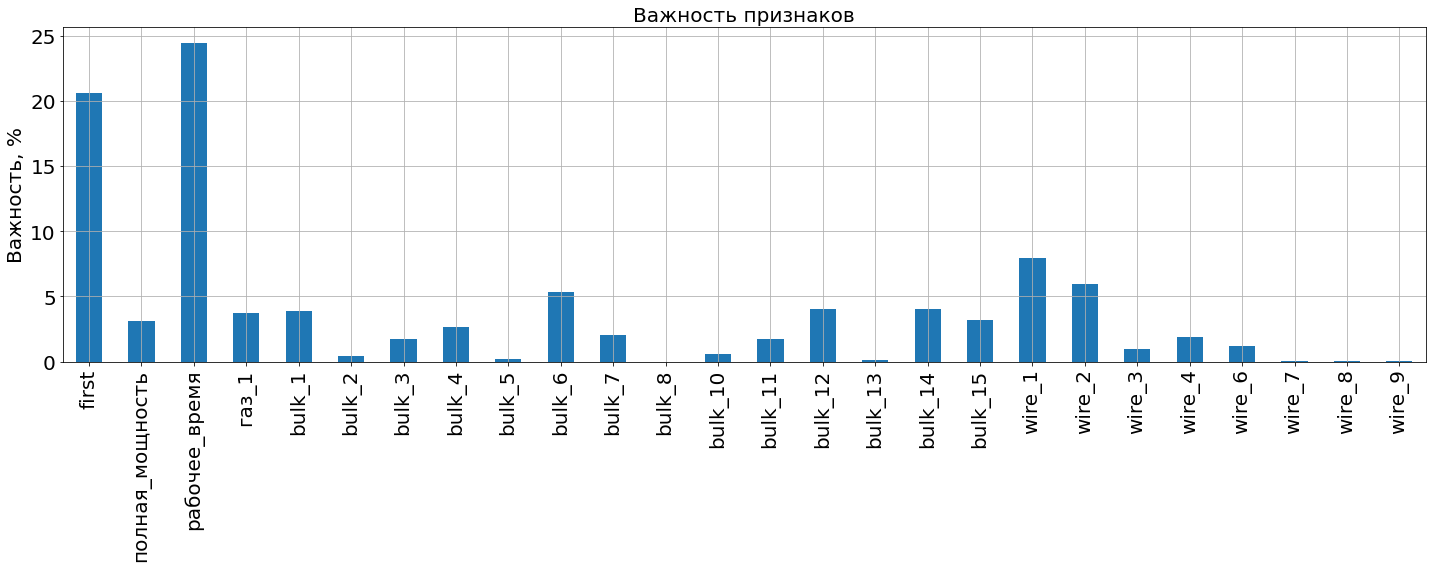

In [153]:
importances = pd.Series(cbr_model.get_feature_importance(), features_train.columns)
fig, ax = plt.subplots(figsize=(20,8))
importances.plot.bar(ax=ax)
ax.set_title("Важность признаков", size=20)
ax.set_ylabel('Важность, %', size=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.grid(axis='y')
plt.grid(axis='x')
fig.tight_layout()

**ТОП-5 Параметров, оказавших наибольшее влияние на работу модели:**
- Время затраченное на нагрев - 24%
- Входая температура ковша - 21%
- Объем добавленной проволоки `wire_1` - 8%
- Объем добавленной проволоки `wire_2` - 7%
- Объем добавленных сыпучих материалов `bulk_6` - 6%

## Общий вывод и рекомендации заказчику

Для анализа и моделирования были предосталвены семь таблиц:  
**data_arc_new.csv** — данные об электродах;  
**data_bulk_new.csv** — данные о подаче сыпучих материалов (объём);  
**data_bulk_time_new.csv** — данные о подаче сыпучих материалов (время);  
**data_gas_new.csv** — данные о продувке сплава газом;  
**data_temp_new.csv** — результаты измерения температуры;  
**data_wire_new.csv** — данные о проволочных материалах (объём);  
**data_wire_time_new.csv** — данные о проволочных материалах (время).
  
**По таблице `data_arc_new`:**  
Размерность датафрейма `data_arc_new` 14876 строк и 5 столбцов.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Пропуски и дубликаты отсутствуют.  
Аномалия выявлена в столбце `реактивная_мощность` - `-715.479924`. Так как объектом моделирования является ковш. Удалены все записи по ковшу `2116` в котором выявлена эта аномалия.  

Добавлен столбец `рабочее_время` с информацией о потраченном на разогрев времени.  
Добавлен столбец `полная_мощность`  в котором посчитана полная электрическая мощность 
потраченная для разогрева стали, по формуле Пифагора: S = √ P^2 + Q^2.  

По итогу предобработки создан датафрейм `data_1`, который включает сгруппированные по ковшу данные, 
планирую использовать эту таблицу для моделирования. `data_1` включает столбцы: `key`, `рабочее_время`, `полная_мощность`.
  
**По таблице `data_bulk_new`:**  
Размерность датафрейма `data_bulk_new` 3129 строк и 16 столбцов.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Дубликаты отсутствуют.  
Большое количество пропусков по столбцам `bulk_1` - `bulk_15`.

Добавлен столбец `итого_bulk`, в котором посчитан общий объем добавленных сыпучих материалов по каждому ковшу и `bulk_count` за какое количество раз они были добавлены в ковш.

Распределение данных в столбце `итого_bulk`стремиться к нормальному, 
но есть несколько всплесков в районе: 100-150, 300, 900. Полагаю это связанно с несколькими источниками 
изначальной стали подаваемой в ковш, поэтому данные не корректировались.  

Данные я не агрегировала в новую таблицу, т.к. каждая строка датафрейма `data_bulk_new` соответствует отдельному ковшу,
и  считаю что в итоговой таблице стоит оставить столбцы `bulk_1` - `bulk_15` поскольку аббревиатурой `bulk_...`
зашифрован определенный химический элемент и раз в процессе производства стали их разделяют, 
значит скорее всего это важно.
  
**По таблице `data_bulk_time_new`:**  
Размерность датафрейма `data_bulk_time_new` 3129 строк и 16 столбцов.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Дубликаты отсутствуют.  
Большое количество пропусков по столбцам `bulk_1` - `bulk_15`

Добавлен столбец `итого_bulk_time`, в котором посчитано какое количество раз
в ковш были добавлены сыпуче материалы. Распределение данных в столбце `итого_bulk_time` имеет нормальный вид. 
Корректировке данные не вносились.

Данные из таблицы `data_bulk_time_new` я не использовались при моделировании.
  
**По таблице `data_gas_new`:**
Размерность датафрейма `data_gas_new` 3239 строк и 2 столбца.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Дубликаты и пропуски отсутствуют.  
Распределение данных по столбцу `газ_1` имеет нормальный вид, 
но у него большое количество выбросов в правую сторону. 
  
**По таблице `data_wire_new`:**
Размерность датафрейма `data_wire_new` 3081 строк и 10 столбцов.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно, дубликаты отсутствуют, пропусков очень много по 
столбцам `wire_1` - `wire_9`.

Учитывая что `wire_1` - `wire_9` это разные виды материалов, сложно оценить адекватность их 
количества, т.к. не известен изначальный состав сплава и неизвестно что именно зашифровано 
за аббревиатурой wire.

Добавлен столбец `итого_wire`, в котором посчитан общий объем добавленных материалов в ковш
Добавлен столбец `итого_wire_count` в котором посчитано какое количество раз 
в ковш добавлялись дополнительные материалы.
Данную таблицу буду использовать при моделировании.
  
**По таблице `data_wire_time_new`:**
Размерность датафрейма `data_wire_time_new` 3081 строк и 10 столбцов.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Дубликаты отсутствуют.  
Большое количество пропусков по столбцам `wire_1` - `wire_9`, аналогично таблице `data_wire_new`.

Добавлен столбец `итого_wire_time` в котором посчитано количество добавленных 
присадок по каждой партии.

Распределение данных по столбцу `итого_wire_time` аналогично распределению в 
таблице `data_wire_new['итого_wire_count']`, что говорит о том что данные загружены 
корректно относительно этих двух датафреймов.
Данные из таблицы `data_wire_time_new` не использовались при моделировании.
  
**По таблице `data_temp_new`:**
Размерность датафрейма `data_temp_new` 18092 строки и 3 столбца.   
Названия столбцов скорректированы и приведены к принятому стандарту.  
Типы данных присвоены верно. Дубликаты отсутствуют.  
Большое количество пропусков по столбцу `температура`.

В данных били выявлены два вида аномалий:**  
- падение температуры ниже 1400
- пропуски по столбцу `температура` в период с 2019-07-14 по 2019-07-17 и 
с 2019-08-09 до конца исследуемого периода. 

Поскольку объектом моделирования является температура ковша перед выплавкой, 
мы не можем использовать ковши по которым нет данных, данные партии придется удалить 
полностью из всех датафреймов.  
Появление пропусков может быть связано с некорректной выгрузкой данных, 
потому что по другим параметрам, например перемешивание газом или добавление bulk и wire, 
данные по мощности не имеют такого количества пропусков по строке.  
Возможно данные по температуре отсутствуют из-за сбоя в оборудовании в момент плавки стали.

Также были удалены аномалии относительно чрезвычайно низких температур,
поскольку температура плавления стали 1450-1520°C из данных были удалены ковши где была
зафиксирована температура ниже 1400.

По итогу предобработки создан датафрейм `data_3`, который включает сгруппированные по ковшу данные.
Целевой метрикой данного проекта является последняя температура ковша 
перед разливом в слябы, также нам нужна первая температура, когда сплав только поместили в ковш,
 как параметр. Промежуточные температуры и время нам не понадобятся для моделирования.

**Таким образом для моделирования были подготовлены следующие таблицы: `data_1`(data_arc_new), `data_bulk_new`, `data_gas_new`, `data_wire_new`,`data_3`(data_temp_new).**  
**Присоединение таблиц производила к таблице `data_3`(data_temp_new) по столбцу `key`.**
  
  
**После объедниения, была произведена следующая предобработка:**  
Финальный датафрейм по итогам предобработки составил 2328 строк и 27 столбца.  
Поле объединения пропуски были заменены  на "0", как корректная замена при отсутствии данных.  

Удален столбец `wire_5` в связи с отсутсвием данных.  

Проведена проверка на мультиколлинеарность, удалены столбцы: `итого_wire_count`, `bulk_count` и `bulk_9`, `итого_wire`,  `итого_bulk` и `итого_добавлено`.    
Для целей обучения, номер партии не имеет значения, поэтому столбец `key` удален.  

По итогу объединения и предобработки итоговый файл был сохранен в размере 75%- 72% от изначального объема выгруженных партий. Индексы обновлены, старые удалены.

Для целей моделирования были выбраны следующие алгоритмы: Линейная регрессия, Случайный лес, CatBoost  
**Налиучший показатель по метрики качества МАЕ показал алгоритм CatBoost: на обучающей выборке - 6,1852, на тестовой выборке - 6,06. Целевой уровень МАЕ <=6,8 достигнут.**

**Гиперпараметры лучшей модели CatBoost: depth': 4, 'iterations': 1500, 'l2_leaf_reg': 1e-20, 'logging_level': 'Silent', 'loss_function': 'MAE', 'random_state': 290124.**

**ТОП-5 Параметров, оказавших наибольшее влияние на работу модели:**
- Время затраченное на нагрев - 24%
- Входая температура ковша - 21%
- Объем добавленной проволоки `wire_1` - 8%
- Объем добавленной проволоки `wire_2` - 7%
- Объем добавленных сыпучих материалов `bulk_6` - 6%

Таким образом можно сказать, что для того чтобы наилучшим образом контролировать температуру ковша, нужно исходить из первичной температуры. Затраченное время на работу нагрева тесно связано с объемом добавленных материалов и имеет отрицательную корреляцию с финальной температурой.  
Чем выше будет качество изначально поданного сырья в ковш, тем меньше будут затраты производителя на электроэнергию и амортизацию.  
Предлагаю также рассмотреть введение на производстве коридора температур, колебания внутри которого будут считаться нормальными. В случае выхода  за пределы коридора оптимальных температур проводить тщательную проверку причин по каждому ковшу: где добыта руда, кем доставлена, какая смена работала, проверка исправности оборудования в период литья этого ковша и т.д. Таким образом можно будет выработать конкретные мероприятия, которые позволят сохранить ресурсы компании.